# Quickstart Example with Synthetic RTB Simulation and Dataset (Data Collection)
This notebook provides an example of visualizing logged dataset collected on RTB environment.

Our example with Synthetic RTB Simualtion and Dataset contains the following 2 cases:
1. Discrete Action Case
2. Continuous Action Case

\* This library uses [d3rlpy](https://github.com/takuseno/d3rlpy)'s algorithm implementations.  
\* Also, our implementations of the data collection module is highly inspired by [Open Bandit Pipeline](https://github.com/st-tech/zr-obp).

In [1]:
# delete later
%load_ext autoreload
%autoreload 2

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [2]:
# delete later
import warnings
warnings.simplefilter('ignore')

In [3]:
# delete later
import sys
sys.path.append('../')
sys.path.append('../../')

In [4]:
# import offlinegym modules
import offlinegym
from rtbgym import RTBEnv, CustomizedRTBEnv
from offlinegym.dataset import SyntheticDataset
from offlinegym.policy import OnlineHead
from offlinegym.ope.online import (
    calc_on_policy_policy_value,
    visualize_on_policy_policy_value,
)

# import d3rlpy algorithms
from d3rlpy.algos import DiscreteRandomPolicy
from d3rlpy.algos import RandomPolicy as ContinuousRandomPolicy
from d3rlpy.preprocessing import MinMaxActionScaler

# import from other libraries
import torch
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.utils import check_random_state

In [5]:
import pickle
from dataclasses import dataclass
from typing import Tuple, Union, Optional
from glob import glob
from tqdm import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [6]:
# version
print(offlinegym.__version__)

0.0.0


In [7]:
# set random state
random_state = 12345
random_ = check_random_state(random_state)

## 0. Description of Synthetic RTB Simulation Environment
To begin with, we briefly describe the basic usage of the environment.

#### RL setup for RTB
In RTB, the objective of the RL agent is to maximize some KPIs (such as numbers of click or conversion) within a episode under the given budget constraints.  
We often try to achieve this by adjusting bidding price function parameter $\alpha$. By using $\alpha$, we adjust bid price as follows.  
$bid_{t,i} = \alpha \cdot r^{\ast}$, 
where $r^{\ast}$ denotes predicted or expected reward (KPIs).

We often formulate this RTB problem as the following Constrained Markov Decision Process (CMDP):
- `timestep`: One episode (a day or a week) consists of several timesteps (24 hours or seven days, for instance).
- `state`: We observe statistical feedback from environment at each timestep, which include following informations.
  - timestep
  - remaining budget
  - impression level features (budget comsuption rate, cost per mille of impressions, auction winning rate, reward) at previous timestep
  - adjust rate (RL agent's decision making) at previous timestep
- `action`: Agent chooses adjust rate parameter $\alpha$ to maximize KPIs.
- `reward`: Total number of clicks or conversions obtained during the timestep.
- `constraints`: The pre-determined episodic budget should not be exceeded.

Let's see how it works!

In [8]:
# setup environment
env = RTBEnv(random_state=random_state)

In [9]:
# define random agent
agent = OnlineHead(
    ContinuousRandomPolicy(
        action_scaler=MinMaxActionScaler(
            minimum=0.1,  # minimum value that policy can take
            maximum=10,  # maximum value that policy can take
        )
    )
)

In [10]:
# interact agent with environment
# only 6 lines needed for RL interaction
for episode in range(10):
    obs = env.reset()
    done = False

    while not done:
        action = agent.predict_online(obs)
        obs, reward, done, info = env.step(action)

In [11]:
# state contains the following statistical feedback from environment
print(env.obs_keys)
print(obs.shape)

['timestep', 'remaining_budget', 'budget_consumption_rate', 'cost_per_mille_of_impression', 'winning_rate', 'reward', 'adjust_rate']
(7,)


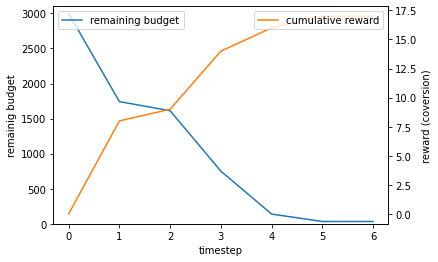

In [12]:
# let's visualize the transition of remaing budget and cumulative reward
# our goal is to gain a policy (i.e., agent) which maximize the cumulative reward under budget constraints using RL.  
# for more visulization, please see appendix.
obs = env.reset()
done = False
remaining_budget = [obs[1]]
cumulative_reward = [0]

while not done:
    action = agent.predict_online(obs)
    obs, reward, done, info = env.step(action)
    remaining_budget.append(obs[1])
    cumulative_reward.append(cumulative_reward[-1] + reward)

# plot
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(remaining_budget[:-1], label='remaining budget')
ax2 = ax1.twinx()
ax2.plot(cumulative_reward[:-1], label='cumulative reward', color='tab:orange')
ax1.set_xlabel('timestep')
ax1.set_ylabel('remainig budget')
ax1.set_ylim(0, env.initial_budget + 100)
ax2.set_ylabel('reward (coversion)')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()

For more about the environmental configuration , please refer to [examples/quickstart/rtb_synthetic_customize_env.ipynb](https://github.com/negocia-inc/rtb_reinforcement_learing/blob/ope/examples/quickstart/rtb_synthetic_customize_env.ipynb).

## 1. Discrete Action Case
Here, we present how to collect logged data by a discrete behavior policy.

The procedure requires two steps:

1. Learn a base deterministic policy
2. Convert the deterministic policy into a stochastic policy.

Below, we first learn a deterministic policy using [d3rlpy](https://github.com/takuseno/d3rlpy).

In [13]:
# setup discrete environment
env = CustomizedRTBEnv(
    original_env=RTBEnv(random_state=random_state),
    reward_predictor=LogisticRegression(),
    action_type="discrete",
)

In [14]:
# learn base deterministic policy for data collection
from d3rlpy.algos import DoubleDQN
from d3rlpy.models.encoders import VectorEncoderFactory
from d3rlpy.models.q_functions import MeanQFunctionFactory
from d3rlpy.online.buffers import ReplayBuffer
from d3rlpy.online.explorers import LinearDecayEpsilonGreedy

# model
ddqn = DoubleDQN(
    encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    q_func_factory=MeanQFunctionFactory(),
    target_update_interval=100,
    use_gpu=torch.cuda.is_available(),
)
# replay buffer
buffer = ReplayBuffer(
    maxlen=10000,
    env=env,
)
# explorers
explorer = LinearDecayEpsilonGreedy(
    start_epsilon=1.0,
    end_epsilon=0.1,
    duration=1000,
)

In [15]:
# start training
# skip if there is a pre-trained model
ddqn.fit_online(
    env,
    buffer,
    explorer=explorer,
    eval_env=env,
    n_steps=100000,
    n_steps_per_epoch=1000,
)

2022-04-09 10:43.10 [info     ] Directory is created at d3rlpy_logs/DoubleDQN_online_20220409104310
2022-04-09 10:43.10 [debug    ] Building model...
2022-04-09 10:43.10 [debug    ] Model has been built.
2022-04-09 10:43.10 [info     ] Parameters are saved to d3rlpy_logs/DoubleDQN_online_20220409104310/params.json params={'action_scaler': None, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'bootstrap': False, 'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_reduction_type': 'min', 'target_update_interval': 100, 'use_gpu': None, 'algorithm

  1%|          | 994/100000 [00:10<13:53, 118.82it/s]

2022-04-09 10:43.21 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220409104310/model_1000.pt
2022-04-09 10:43.21 [info     ] DoubleDQN_online_20220409104310: epoch=1 step=1000 epoch=1 metrics={'time_inference': 0.0004383804798126221, 'time_environment_step': 0.0007943112509591238, 'time_step': 0.009758198022842408, 'rollout_return': 11.408, 'time_sample_batch': 9.47083763368157e-05, 'time_algorithm_update': 0.008787581234829943, 'loss': 81.75558272329074, 'evaluation': 6.6} step=1000


  2%|▏         | 1995/100000 [00:21<17:31, 93.24it/s] 

2022-04-09 10:43.32 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220409104310/model_2000.pt
2022-04-09 10:43.32 [info     ] DoubleDQN_online_20220409104310: epoch=2 step=2000 epoch=2 metrics={'time_inference': 0.00044949889183044434, 'time_environment_step': 0.0009082126617431641, 'time_sample_batch': 0.00011384749412536622, 'time_algorithm_update': 0.008376822471618653, 'loss': 20.64971269893646, 'time_step': 0.009799188137054443, 'rollout_return': 3.304, 'evaluation': 0.0} step=2000


  3%|▎         | 2999/100000 [00:32<14:33, 111.10it/s]

2022-04-09 10:43.43 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220409104310/model_3000.pt
2022-04-09 10:43.43 [info     ] DoubleDQN_online_20220409104310: epoch=3 step=3000 epoch=3 metrics={'time_inference': 0.0004188499450683594, 'time_environment_step': 0.0009045982360839843, 'time_sample_batch': 9.821343421936035e-05, 'time_algorithm_update': 0.008343718528747558, 'loss': 17.42278011929989, 'time_step': 0.009737107276916504, 'rollout_return': 1.624, 'evaluation': 0.0} step=3000


  4%|▍         | 3990/100000 [00:43<14:47, 108.23it/s]

2022-04-09 10:43.54 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220409104310/model_4000.pt
2022-04-09 10:43.54 [info     ] DoubleDQN_online_20220409104310: epoch=4 step=4000 epoch=4 metrics={'time_inference': 0.00041031599044799805, 'time_environment_step': 0.0009345708574567522, 'time_sample_batch': 0.00011797046661376952, 'time_algorithm_update': 0.008228450059890747, 'loss': 15.990140241742134, 'time_step': 0.009652562618255615, 'rollout_return': 2.048, 'evaluation': 0.0} step=4000


  5%|▍         | 4992/100000 [00:53<16:39, 95.10it/s] 

2022-04-09 10:44.04 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220409104310/model_5000.pt
2022-04-09 10:44.04 [info     ] DoubleDQN_online_20220409104310: epoch=5 step=5000 epoch=5 metrics={'time_inference': 0.00045887637138366697, 'time_environment_step': 0.0008697362627301898, 'time_sample_batch': 0.0001068120002746582, 'time_algorithm_update': 0.007996906757354736, 'loss': 14.57697827076912, 'time_step': 0.009427617073059082, 'rollout_return': 1.552, 'evaluation': 0.0} step=5000


  6%|▌         | 5991/100000 [01:04<19:45, 79.27it/s] 

2022-04-09 10:44.15 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220409104310/model_6000.pt
2022-04-09 10:44.15 [info     ] DoubleDQN_online_20220409104310: epoch=6 step=6000 epoch=6 metrics={'time_inference': 0.00045008468627929686, 'time_environment_step': 0.0008309042794363839, 'time_sample_batch': 0.00011132431030273437, 'time_algorithm_update': 0.008107345819473267, 'loss': 13.333369065761566, 'time_step': 0.009462646961212158, 'rollout_return': 1.944, 'evaluation': 0.0} step=6000


  7%|▋         | 6993/100000 [01:16<18:11, 85.18it/s] 

2022-04-09 10:44.27 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220409104310/model_7000.pt
2022-04-09 10:44.27 [info     ] DoubleDQN_online_20220409104310: epoch=7 step=7000 epoch=7 metrics={'time_inference': 0.00047772932052612304, 'time_environment_step': 0.0009999716622488839, 'time_sample_batch': 0.00012063789367675782, 'time_algorithm_update': 0.009610209465026855, 'loss': 11.913201614379883, 'time_step': 0.011186153888702392, 'rollout_return': 1.56, 'evaluation': 0.0} step=7000


  8%|▊         | 7983/100000 [01:29<18:41, 82.07it/s] 

2022-04-09 10:44.40 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220409104310/model_8000.pt
2022-04-09 10:44.40 [info     ] DoubleDQN_online_20220409104310: epoch=8 step=8000 epoch=8 metrics={'time_inference': 0.000546875, 'time_environment_step': 0.0010459755488804409, 'time_sample_batch': 0.0001605536937713623, 'time_algorithm_update': 0.009459677457809448, 'loss': 10.255331767380238, 'time_step': 0.011215070009231567, 'rollout_return': 1.56, 'evaluation': 0.7} step=8000


  9%|▉         | 8999/100000 [01:43<19:03, 79.56it/s] 

2022-04-09 10:44.53 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220409104310/model_9000.pt
2022-04-09 10:44.53 [info     ] DoubleDQN_online_20220409104310: epoch=9 step=9000 epoch=9 metrics={'time_inference': 0.0005894341468811035, 'time_environment_step': 0.0010896429334368025, 'time_sample_batch': 0.0001291794776916504, 'time_algorithm_update': 0.010344660520553588, 'loss': 9.06722025758028, 'time_step': 0.012103773355484009, 'rollout_return': 1.872, 'evaluation': 0.0} step=9000


 10%|▉         | 9992/100000 [01:56<22:37, 66.28it/s] 

2022-04-09 10:45.07 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220409104310/model_10000.pt
2022-04-09 10:45.07 [info     ] DoubleDQN_online_20220409104310: epoch=10 step=10000 epoch=10 metrics={'time_inference': 0.0004797658920288086, 'time_environment_step': 0.001110762187412807, 'time_sample_batch': 0.00012326860427856444, 'time_algorithm_update': 0.010578906297683715, 'loss': 7.737881135806441, 'time_step': 0.012282861232757568, 'rollout_return': 1.968, 'evaluation': 0.0} step=10000


 11%|█         | 10990/100000 [02:09<16:02, 92.49it/s] 

2022-04-09 10:45.19 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220409104310/model_11000.pt
2022-04-09 10:45.19 [info     ] DoubleDQN_online_20220409104310: epoch=11 step=11000 epoch=11 metrics={'time_inference': 0.0005158493518829345, 'time_environment_step': 0.0010252663748604911, 'time_sample_batch': 0.00011716413497924805, 'time_algorithm_update': 0.009536105155944824, 'loss': 6.843087002336979, 'time_step': 0.011147902965545655, 'rollout_return': 1.608, 'evaluation': 0.0} step=11000


 12%|█▏        | 11995/100000 [02:22<20:52, 70.26it/s] 

2022-04-09 10:45.33 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220409104310/model_12000.pt
2022-04-09 10:45.33 [info     ] DoubleDQN_online_20220409104310: epoch=12 step=12000 epoch=12 metrics={'time_inference': 0.0005633411407470703, 'time_environment_step': 0.0010113468170166015, 'time_sample_batch': 0.00014359045028686522, 'time_algorithm_update': 0.010508015155792236, 'loss': 5.859911782056093, 'time_step': 0.012182143449783325, 'rollout_return': 2.232, 'evaluation': 0.0} step=12000


 13%|█▎        | 12994/100000 [02:36<20:13, 71.71it/s] 

2022-04-09 10:45.46 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220409104310/model_13000.pt
2022-04-09 10:45.46 [info     ] DoubleDQN_online_20220409104310: epoch=13 step=13000 epoch=13 metrics={'time_inference': 0.0005401535034179688, 'time_environment_step': 0.001008411407470703, 'time_sample_batch': 0.00011069965362548828, 'time_algorithm_update': 0.010118475914001465, 'loss': 5.1485669109001755, 'time_step': 0.011730474472045898, 'rollout_return': 1.96, 'evaluation': 0.0} step=13000


 14%|█▍        | 13991/100000 [02:50<19:29, 73.56it/s] 

2022-04-09 10:46.01 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220409104310/model_14000.pt
2022-04-09 10:46.01 [info     ] DoubleDQN_online_20220409104310: epoch=14 step=14000 epoch=14 metrics={'time_inference': 0.0005207781791687012, 'time_environment_step': 0.0010638757433210101, 'time_sample_batch': 0.0001399517059326172, 'time_algorithm_update': 0.01129369568824768, 'loss': 4.335623014785349, 'time_step': 0.012988648653030396, 'rollout_return': 2.336, 'evaluation': 0.0} step=14000


 15%|█▍        | 14993/100000 [03:03<15:15, 92.86it/s] 

2022-04-09 10:46.14 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220409104310/model_15000.pt
2022-04-09 10:46.14 [info     ] DoubleDQN_online_20220409104310: epoch=15 step=15000 epoch=15 metrics={'time_inference': 0.0005449748039245605, 'time_environment_step': 0.0010790181841169085, 'time_sample_batch': 0.00013085532188415527, 'time_algorithm_update': 0.00990828537940979, 'loss': 4.0071295380443335, 'time_step': 0.011632995128631592, 'rollout_return': 3.976, 'evaluation': 0.0} step=15000


 16%|█▌        | 15988/100000 [03:17<12:38, 110.82it/s]

2022-04-09 10:46.28 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220409104310/model_16000.pt
2022-04-09 10:46.28 [info     ] DoubleDQN_online_20220409104310: epoch=16 step=16000 epoch=16 metrics={'time_inference': 0.0005079765319824219, 'time_environment_step': 0.0011518614632742745, 'time_sample_batch': 0.00015076088905334472, 'time_algorithm_update': 0.010215450763702392, 'loss': 3.097519725330174, 'time_step': 0.011971429824829101, 'rollout_return': 4.016, 'evaluation': 11.6} step=16000


 17%|█▋        | 16996/100000 [03:30<16:24, 84.35it/s] 

2022-04-09 10:46.40 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220409104310/model_17000.pt
2022-04-09 10:46.40 [info     ] DoubleDQN_online_20220409104310: epoch=17 step=17000 epoch=17 metrics={'time_inference': 0.0005692462921142578, 'time_environment_step': 0.0009469988686697824, 'time_sample_batch': 0.00015525174140930176, 'time_algorithm_update': 0.009587263822555541, 'loss': 2.6472345617711546, 'time_step': 0.011225838899612426, 'rollout_return': 6.744, 'evaluation': 9.2} step=17000


 18%|█▊        | 17992/100000 [03:43<16:23, 83.40it/s] 

2022-04-09 10:46.54 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220409104310/model_18000.pt
2022-04-09 10:46.54 [info     ] DoubleDQN_online_20220409104310: epoch=18 step=18000 epoch=18 metrics={'time_inference': 0.0005236074924468994, 'time_environment_step': 0.0010513425554547992, 'time_sample_batch': 0.00014478588104248046, 'time_algorithm_update': 0.010152856349945068, 'loss': 2.239230563521385, 'time_step': 0.011821927309036254, 'rollout_return': 8.712, 'evaluation': 9.8} step=18000


 19%|█▉        | 18997/100000 [03:55<20:59, 64.33it/s] 

2022-04-09 10:47.06 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220409104310/model_19000.pt
2022-04-09 10:47.06 [info     ] DoubleDQN_online_20220409104310: epoch=19 step=19000 epoch=19 metrics={'time_inference': 0.0005281484127044678, 'time_environment_step': 0.0010647953578404017, 'time_sample_batch': 0.00013584423065185548, 'time_algorithm_update': 0.009590323686599731, 'loss': 1.797654140472412, 'time_step': 0.011295225620269776, 'rollout_return': 10.44, 'evaluation': 12.8} step=19000


 20%|█▉        | 19996/100000 [04:09<16:28, 80.92it/s] 

2022-04-09 10:47.19 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220409104310/model_20000.pt
2022-04-09 10:47.19 [info     ] DoubleDQN_online_20220409104310: epoch=20 step=20000 epoch=20 metrics={'time_inference': 0.0005655720233917236, 'time_environment_step': 0.0010038762773786271, 'time_sample_batch': 0.00013912439346313476, 'time_algorithm_update': 0.00997020149230957, 'loss': 1.717500502705574, 'time_step': 0.011662376642227173, 'rollout_return': 13.04, 'evaluation': 0.0} step=20000


 21%|██        | 20991/100000 [04:22<17:39, 74.56it/s] 

2022-04-09 10:47.33 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220409104310/model_21000.pt
2022-04-09 10:47.33 [info     ] DoubleDQN_online_20220409104310: epoch=21 step=21000 epoch=21 metrics={'time_inference': 0.0004820842742919922, 'time_environment_step': 0.0010037354060581753, 'time_sample_batch': 0.00013061213493347168, 'time_algorithm_update': 0.010326988935470582, 'loss': 1.5292128657698631, 'time_step': 0.011901757717132568, 'rollout_return': 13.568, 'evaluation': 13.8} step=21000


 22%|██▏       | 21994/100000 [04:36<18:36, 69.86it/s] 

2022-04-09 10:47.47 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220409104310/model_22000.pt
2022-04-09 10:47.47 [info     ] DoubleDQN_online_20220409104310: epoch=22 step=22000 epoch=22 metrics={'time_inference': 0.0005618379116058349, 'time_environment_step': 0.0010830685751778738, 'time_sample_batch': 0.00014011955261230468, 'time_algorithm_update': 0.011119850397109986, 'loss': 1.5213392463922502, 'time_step': 0.012877866506576538, 'rollout_return': 13.648, 'evaluation': 15.0} step=22000


 23%|██▎       | 22996/100000 [04:51<12:48, 100.18it/s]

2022-04-09 10:48.02 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220409104310/model_23000.pt
2022-04-09 10:48.02 [info     ] DoubleDQN_online_20220409104310: epoch=23 step=23000 epoch=23 metrics={'time_inference': 0.0005469965934753418, 'time_environment_step': 0.001146904264177595, 'time_sample_batch': 0.00014179134368896485, 'time_algorithm_update': 0.011485614538192749, 'loss': 1.3325466319918633, 'time_step': 0.013285982608795165, 'rollout_return': 14.344, 'evaluation': 15.6} step=23000


 24%|██▍       | 23996/100000 [05:04<21:14, 59.64it/s] 

2022-04-09 10:48.15 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220409104310/model_24000.pt
2022-04-09 10:48.15 [info     ] DoubleDQN_online_20220409104310: epoch=24 step=24000 epoch=24 metrics={'time_inference': 0.0005092942714691163, 'time_environment_step': 0.0010374772208077566, 'time_sample_batch': 0.00017116713523864747, 'time_algorithm_update': 0.00974907398223877, 'loss': 1.4087964356541633, 'time_step': 0.011440199613571168, 'rollout_return': 13.4, 'evaluation': 16.2} step=24000


 25%|██▍       | 24990/100000 [05:19<11:04, 112.87it/s]

2022-04-09 10:48.30 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220409104310/model_25000.pt
2022-04-09 10:48.30 [info     ] DoubleDQN_online_20220409104310: epoch=25 step=25000 epoch=25 metrics={'time_inference': 0.0005581352710723877, 'time_environment_step': 0.0010324769701276506, 'time_sample_batch': 0.00012793326377868653, 'time_algorithm_update': 0.011834378957748413, 'loss': 1.285704735249281, 'time_step': 0.01352825379371643, 'rollout_return': 14.936, 'evaluation': 15.0} step=25000


 26%|██▌       | 25986/100000 [05:34<17:44, 69.50it/s] 

2022-04-09 10:48.45 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220409104310/model_26000.pt
2022-04-09 10:48.45 [info     ] DoubleDQN_online_20220409104310: epoch=26 step=26000 epoch=26 metrics={'time_inference': 0.000503307580947876, 'time_environment_step': 0.0011060951777866908, 'time_sample_batch': 0.0001299724578857422, 'time_algorithm_update': 0.011620462894439697, 'loss': 1.219041158363223, 'time_step': 0.013323018789291381, 'rollout_return': 14.04, 'evaluation': 7.9} step=26000


 27%|██▋       | 26990/100000 [05:48<14:51, 81.88it/s] 

2022-04-09 10:48.59 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220409104310/model_27000.pt
2022-04-09 10:48.59 [info     ] DoubleDQN_online_20220409104310: epoch=27 step=27000 epoch=27 metrics={'time_inference': 0.0005129215717315674, 'time_environment_step': 0.0010519354684012277, 'time_sample_batch': 0.00014398384094238282, 'time_algorithm_update': 0.010652340412139893, 'loss': 1.1667360240221023, 'time_step': 0.012335827350616455, 'rollout_return': 13.352, 'evaluation': 15.4} step=27000


 28%|██▊       | 27998/100000 [06:00<17:27, 68.74it/s] 

2022-04-09 10:49.11 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220409104310/model_28000.pt
2022-04-09 10:49.11 [info     ] DoubleDQN_online_20220409104310: epoch=28 step=28000 epoch=28 metrics={'time_inference': 0.0004971902370452881, 'time_environment_step': 0.000991994857788086, 'time_sample_batch': 0.00012783432006835939, 'time_algorithm_update': 0.009370930194854736, 'loss': 1.153416308104992, 'time_step': 0.01093372678756714, 'rollout_return': 11.904, 'evaluation': 7.0} step=28000


 29%|██▉       | 28997/100000 [06:14<20:13, 58.51it/s] 

2022-04-09 10:49.25 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220409104310/model_29000.pt
2022-04-09 10:49.25 [info     ] DoubleDQN_online_20220409104310: epoch=29 step=29000 epoch=29 metrics={'time_inference': 0.0005288469791412353, 'time_environment_step': 0.0010159726824079242, 'time_sample_batch': 0.00012658834457397462, 'time_algorithm_update': 0.01070624876022339, 'loss': 1.0710935069918632, 'time_step': 0.012343922853469849, 'rollout_return': 14.176, 'evaluation': 5.6} step=29000


 30%|██▉       | 29989/100000 [06:27<12:19, 94.68it/s] 

2022-04-09 10:49.38 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220409104310/model_30000.pt
2022-04-09 10:49.38 [info     ] DoubleDQN_online_20220409104310: epoch=30 step=30000 epoch=30 metrics={'time_inference': 0.0005154988765716553, 'time_environment_step': 0.0010380872998918807, 'time_sample_batch': 0.00010904526710510255, 'time_algorithm_update': 0.009849656105041503, 'loss': 0.960840016335249, 'time_step': 0.01148701024055481, 'rollout_return': 13.256, 'evaluation': 19.1} step=30000


 31%|███       | 30994/100000 [06:40<18:33, 61.96it/s] 

2022-04-09 10:49.51 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220409104310/model_31000.pt
2022-04-09 10:49.51 [info     ] DoubleDQN_online_20220409104310: epoch=31 step=31000 epoch=31 metrics={'time_inference': 0.0005239143371582032, 'time_environment_step': 0.0009758254459926061, 'time_sample_batch': 0.00011520814895629883, 'time_algorithm_update': 0.010103314876556397, 'loss': 1.0011836939156056, 'time_step': 0.011697712182998657, 'rollout_return': 12.904, 'evaluation': 16.3} step=31000


 32%|███▏      | 31992/100000 [06:54<14:07, 80.21it/s] 

2022-04-09 10:50.05 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220409104310/model_32000.pt
2022-04-09 10:50.05 [info     ] DoubleDQN_online_20220409104310: epoch=32 step=32000 epoch=32 metrics={'time_inference': 0.0005511796474456787, 'time_environment_step': 0.0009906608036586216, 'time_sample_batch': 0.00012759184837341308, 'time_algorithm_update': 0.010556941509246826, 'loss': 0.9090441651046276, 'time_step': 0.012217124223709106, 'rollout_return': 15.064, 'evaluation': 15.5} step=32000


 33%|███▎      | 32996/100000 [07:09<15:11, 73.53it/s] 

2022-04-09 10:50.20 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220409104310/model_33000.pt
2022-04-09 10:50.20 [info     ] DoubleDQN_online_20220409104310: epoch=33 step=33000 epoch=33 metrics={'time_inference': 0.0006206352710723877, 'time_environment_step': 0.001137387956891741, 'time_sample_batch': 0.00013862466812133788, 'time_algorithm_update': 0.011676784515380859, 'loss': 0.9178469399660826, 'time_step': 0.013559291124343871, 'rollout_return': 14.376, 'evaluation': 15.0} step=33000


 34%|███▍      | 33999/100000 [07:24<18:34, 59.22it/s] 

2022-04-09 10:50.35 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220409104310/model_34000.pt
2022-04-09 10:50.35 [info     ] DoubleDQN_online_20220409104310: epoch=34 step=34000 epoch=34 metrics={'time_inference': 0.0006842305660247803, 'time_environment_step': 0.001220799309866769, 'time_sample_batch': 0.00014651751518249511, 'time_algorithm_update': 0.011174878120422364, 'loss': 0.936464878052473, 'time_step': 0.01320808720588684, 'rollout_return': 15.728, 'evaluation': 15.0} step=34000


 35%|███▍      | 34991/100000 [07:39<17:33, 61.69it/s] 

2022-04-09 10:50.50 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220409104310/model_35000.pt
2022-04-09 10:50.50 [info     ] DoubleDQN_online_20220409104310: epoch=35 step=35000 epoch=35 metrics={'time_inference': 0.0005850193500518798, 'time_environment_step': 0.001061185564313616, 'time_sample_batch': 0.00016077542304992676, 'time_algorithm_update': 0.011904926538467408, 'loss': 0.8951466439515352, 'time_step': 0.013659323215484619, 'rollout_return': 14.608, 'evaluation': 15.8} step=35000


 36%|███▌      | 35992/100000 [07:56<14:04, 75.83it/s] 

2022-04-09 10:51.06 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220409104310/model_36000.pt
2022-04-09 10:51.07 [info     ] DoubleDQN_online_20220409104310: epoch=36 step=36000 epoch=36 metrics={'time_inference': 0.0006137516498565674, 'time_environment_step': 0.0012552032470703124, 'time_sample_batch': 0.0001559884548187256, 'time_algorithm_update': 0.012534240484237671, 'loss': 0.859019916087389, 'time_step': 0.014504560470581055, 'rollout_return': 14.984, 'evaluation': 14.1} step=36000


 37%|███▋      | 36993/100000 [08:11<10:12, 102.82it/s]

2022-04-09 10:51.22 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220409104310/model_37000.pt
2022-04-09 10:51.22 [info     ] DoubleDQN_online_20220409104310: epoch=37 step=37000 epoch=37 metrics={'time_inference': 0.0006740186214447022, 'time_environment_step': 0.0012952559334891184, 'time_sample_batch': 0.0001445794105529785, 'time_algorithm_update': 0.01174904179573059, 'loss': 0.8853290016651154, 'time_step': 0.013805330514907836, 'rollout_return': 14.528, 'evaluation': 16.5} step=37000


 38%|███▊      | 37999/100000 [08:24<13:37, 75.87it/s] 

2022-04-09 10:51.35 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220409104310/model_38000.pt
2022-04-09 10:51.35 [info     ] DoubleDQN_online_20220409104310: epoch=38 step=38000 epoch=38 metrics={'time_inference': 0.0004976811408996582, 'time_environment_step': 0.0009788919176374163, 'time_sample_batch': 0.00013504433631896973, 'time_algorithm_update': 0.009824888467788697, 'loss': 0.9107533030807972, 'time_step': 0.011419260740280152, 'rollout_return': 14.864, 'evaluation': 14.4} step=38000


 39%|███▉      | 38999/100000 [08:38<16:12, 62.70it/s] 

2022-04-09 10:51.49 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220409104310/model_39000.pt
2022-04-09 10:51.49 [info     ] DoubleDQN_online_20220409104310: epoch=39 step=39000 epoch=39 metrics={'time_inference': 0.0005204310417175293, 'time_environment_step': 0.0009402754647391184, 'time_sample_batch': 0.00013797950744628905, 'time_algorithm_update': 0.010375336647033691, 'loss': 0.8564949559122323, 'time_step': 0.011953898668289185, 'rollout_return': 14.768, 'evaluation': 10.9} step=39000


 40%|███▉      | 39990/100000 [08:50<10:07, 98.83it/s] 

2022-04-09 10:52.01 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220409104310/model_40000.pt
2022-04-09 10:52.01 [info     ] DoubleDQN_online_20220409104310: epoch=40 step=40000 epoch=40 metrics={'time_inference': 0.0004985096454620361, 'time_environment_step': 0.0009320558820452009, 'time_sample_batch': 0.00011407351493835449, 'time_algorithm_update': 0.009526021718978882, 'loss': 0.8669244074523449, 'time_step': 0.011048568487167358, 'rollout_return': 14.4, 'evaluation': 14.5} step=40000


 41%|████      | 40994/100000 [09:03<10:07, 97.11it/s] 

2022-04-09 10:52.14 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220409104310/model_41000.pt
2022-04-09 10:52.14 [info     ] DoubleDQN_online_20220409104310: epoch=41 step=41000 epoch=41 metrics={'time_inference': 0.000528407335281372, 'time_environment_step': 0.0009989406040736607, 'time_sample_batch': 0.00014428210258483887, 'time_algorithm_update': 0.009570756196975708, 'loss': 0.8450925969034433, 'time_step': 0.011202682018280029, 'rollout_return': 14.464, 'evaluation': 15.6} step=41000


 42%|████▏     | 41995/100000 [09:17<11:16, 85.68it/s] 

2022-04-09 10:52.28 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220409104310/model_42000.pt
2022-04-09 10:52.28 [info     ] DoubleDQN_online_20220409104310: epoch=42 step=42000 epoch=42 metrics={'time_inference': 0.0005197908878326416, 'time_environment_step': 0.0010582283564976283, 'time_sample_batch': 0.00017222213745117187, 'time_algorithm_update': 0.011160519123077393, 'loss': 0.803369858533144, 'time_step': 0.012884175539016723, 'rollout_return': 14.848, 'evaluation': 15.8} step=42000


 43%|████▎     | 42999/100000 [09:32<15:36, 60.89it/s] 

2022-04-09 10:52.43 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220409104310/model_43000.pt
2022-04-09 10:52.43 [info     ] DoubleDQN_online_20220409104310: epoch=43 step=43000 epoch=43 metrics={'time_inference': 0.0005507235527038574, 'time_environment_step': 0.0011516036987304688, 'time_sample_batch': 0.00013613057136535643, 'time_algorithm_update': 0.011379628419876098, 'loss': 0.7952976483404637, 'time_step': 0.013180697202682496, 'rollout_return': 14.688, 'evaluation': 17.5} step=43000


 44%|████▍     | 43997/100000 [09:47<10:45, 86.72it/s] 

2022-04-09 10:52.58 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220409104310/model_44000.pt
2022-04-09 10:52.58 [info     ] DoubleDQN_online_20220409104310: epoch=44 step=44000 epoch=44 metrics={'time_inference': 0.000576425313949585, 'time_environment_step': 0.0011540208544049944, 'time_sample_batch': 0.00015935659408569336, 'time_algorithm_update': 0.011746968030929566, 'loss': 0.8151397702991963, 'time_step': 0.01358570909500122, 'rollout_return': 14.68, 'evaluation': 16.4} step=44000


 45%|████▍     | 44996/100000 [10:01<19:34, 46.83it/s] 

2022-04-09 10:53.11 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220409104310/model_45000.pt
2022-04-09 10:53.11 [info     ] DoubleDQN_online_20220409104310: epoch=45 step=45000 epoch=45 metrics={'time_inference': 0.0005805480480194092, 'time_environment_step': 0.000995770045689174, 'time_sample_batch': 0.0001483912467956543, 'time_algorithm_update': 0.010049875259399415, 'loss': 0.8187926879674197, 'time_step': 0.011740458726882935, 'rollout_return': 15.048, 'evaluation': 15.4} step=45000


 46%|████▌     | 45992/100000 [10:15<10:51, 82.84it/s] 

2022-04-09 10:53.26 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220409104310/model_46000.pt
2022-04-09 10:53.26 [info     ] DoubleDQN_online_20220409104310: epoch=46 step=46000 epoch=46 metrics={'time_inference': 0.0006307439804077149, 'time_environment_step': 0.0010497469220842634, 'time_sample_batch': 0.00012035441398620605, 'time_algorithm_update': 0.011375688076019286, 'loss': 0.7914663619101048, 'time_step': 0.013175013065338135, 'rollout_return': 15.192, 'evaluation': 16.6} step=46000


 47%|████▋     | 46991/100000 [10:30<12:14, 72.19it/s] 

2022-04-09 10:53.41 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220409104310/model_47000.pt
2022-04-09 10:53.41 [info     ] DoubleDQN_online_20220409104310: epoch=47 step=47000 epoch=47 metrics={'time_inference': 0.0005249099731445313, 'time_environment_step': 0.0011593453543526785, 'time_sample_batch': 0.00013270711898803712, 'time_algorithm_update': 0.011480577945709228, 'loss': 0.8151353057473898, 'time_step': 0.013235214233398438, 'rollout_return': 15.056, 'evaluation': 13.4} step=47000


 48%|████▊     | 47990/100000 [10:43<08:24, 103.07it/s]

2022-04-09 10:53.53 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220409104310/model_48000.pt
2022-04-09 10:53.54 [info     ] DoubleDQN_online_20220409104310: epoch=48 step=48000 epoch=48 metrics={'time_inference': 0.0005522725582122802, 'time_environment_step': 0.0009776107243129185, 'time_sample_batch': 0.0001425964832305908, 'time_algorithm_update': 0.009332704067230224, 'loss': 0.8091585415899754, 'time_step': 0.01096143651008606, 'rollout_return': 14.648, 'evaluation': 16.6} step=48000


 49%|████▉     | 48997/100000 [11:01<15:53, 53.47it/s] 

2022-04-09 10:54.11 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220409104310/model_49000.pt
2022-04-09 10:54.11 [info     ] DoubleDQN_online_20220409104310: epoch=49 step=49000 epoch=49 metrics={'time_inference': 0.0005605962276458741, 'time_environment_step': 0.0011630635942731584, 'time_sample_batch': 0.00014074349403381348, 'time_algorithm_update': 0.013898505687713622, 'loss': 0.7725182664394379, 'time_step': 0.01572851490974426, 'rollout_return': 14.272, 'evaluation': 16.3} step=49000


 50%|████▉     | 49990/100000 [11:14<12:51, 64.80it/s] 

2022-04-09 10:54.25 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220409104310/model_50000.pt
2022-04-09 10:54.25 [info     ] DoubleDQN_online_20220409104310: epoch=50 step=50000 epoch=50 metrics={'time_inference': 0.0005231425762176514, 'time_environment_step': 0.0009585633959089007, 'time_sample_batch': 0.00010497593879699707, 'time_algorithm_update': 0.01054234552383423, 'loss': 0.7655419373065233, 'time_step': 0.012084706544876098, 'rollout_return': 14.912, 'evaluation': 18.0} step=50000


 51%|█████     | 50994/100000 [11:30<15:36, 52.35it/s] 

2022-04-09 10:54.41 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220409104310/model_51000.pt
2022-04-09 10:54.41 [info     ] DoubleDQN_online_20220409104310: epoch=51 step=51000 epoch=51 metrics={'time_inference': 0.0006055631637573243, 'time_environment_step': 0.0010946578979492189, 'time_sample_batch': 0.00012328577041625976, 'time_algorithm_update': 0.0120827739238739, 'loss': 0.7943010714948178, 'time_step': 0.013883456707000733, 'rollout_return': 15.064, 'evaluation': 8.1} step=51000


 52%|█████▏    | 51992/100000 [11:42<12:49, 62.38it/s] 

2022-04-09 10:54.53 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220409104310/model_52000.pt
2022-04-09 10:54.53 [info     ] DoubleDQN_online_20220409104310: epoch=52 step=52000 epoch=52 metrics={'time_inference': 0.0004724206924438477, 'time_environment_step': 0.0009873455592564174, 'time_sample_batch': 0.0001214759349822998, 'time_algorithm_update': 0.009586812257766723, 'loss': 0.7598638374805451, 'time_step': 0.011122397661209106, 'rollout_return': 15.28, 'evaluation': 16.9} step=52000


 53%|█████▎    | 52995/100000 [11:57<09:36, 81.53it/s] 

2022-04-09 10:55.08 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220409104310/model_53000.pt
2022-04-09 10:55.08 [info     ] DoubleDQN_online_20220409104310: epoch=53 step=53000 epoch=53 metrics={'time_inference': 0.0005100691318511963, 'time_environment_step': 0.000966820308140346, 'time_sample_batch': 0.0001205911636352539, 'time_algorithm_update': 0.01144897437095642, 'loss': 0.7771169249564409, 'time_step': 0.013006374835968018, 'rollout_return': 14.4, 'evaluation': 19.5} step=53000


 54%|█████▍    | 53999/100000 [12:12<10:19, 74.26it/s]

2022-04-09 10:55.22 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220409104310/model_54000.pt
2022-04-09 10:55.22 [info     ] DoubleDQN_online_20220409104310: epoch=54 step=54000 epoch=54 metrics={'time_inference': 0.0006247560977935791, 'time_environment_step': 0.00110504640851702, 'time_sample_batch': 0.00013651299476623535, 'time_algorithm_update': 0.0111147301197052, 'loss': 0.7612881442457438, 'time_step': 0.012945850133895874, 'rollout_return': 15.408, 'evaluation': 12.3} step=54000


 55%|█████▍    | 54992/100000 [12:26<13:53, 53.97it/s] 

2022-04-09 10:55.37 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220409104310/model_55000.pt
2022-04-09 10:55.37 [info     ] DoubleDQN_online_20220409104310: epoch=55 step=55000 epoch=55 metrics={'time_inference': 0.0004974792003631592, 'time_environment_step': 0.0011468470437186104, 'time_sample_batch': 0.00015334248542785644, 'time_algorithm_update': 0.011200107097625733, 'loss': 0.7674197842031717, 'time_step': 0.012935338735580445, 'rollout_return': 15.16, 'evaluation': 16.2} step=55000


 56%|█████▌    | 55997/100000 [12:41<10:26, 70.27it/s] 

2022-04-09 10:55.52 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220409104310/model_56000.pt
2022-04-09 10:55.52 [info     ] DoubleDQN_online_20220409104310: epoch=56 step=56000 epoch=56 metrics={'time_inference': 0.0005880537033081055, 'time_environment_step': 0.0011244942801339286, 'time_sample_batch': 0.00012549614906311036, 'time_algorithm_update': 0.011240796089172363, 'loss': 0.7670401737391949, 'time_step': 0.013052107334136963, 'rollout_return': 14.76, 'evaluation': 6.5} step=56000


 57%|█████▋    | 56993/100000 [12:54<16:11, 44.26it/s] 

2022-04-09 10:56.05 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220409104310/model_57000.pt
2022-04-09 10:56.05 [info     ] DoubleDQN_online_20220409104310: epoch=57 step=57000 epoch=57 metrics={'time_inference': 0.0005386574268341065, 'time_environment_step': 0.0009340722220284598, 'time_sample_batch': 0.00011176848411560059, 'time_algorithm_update': 0.010498851776123046, 'loss': 0.7480589037388563, 'time_step': 0.012049712657928468, 'rollout_return': 14.768, 'evaluation': 17.4} step=57000


 58%|█████▊    | 57997/100000 [13:10<11:23, 61.47it/s]

2022-04-09 10:56.20 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220409104310/model_58000.pt
2022-04-09 10:56.20 [info     ] DoubleDQN_online_20220409104310: epoch=58 step=58000 epoch=58 metrics={'time_inference': 0.000621044397354126, 'time_environment_step': 0.0011645954677036831, 'time_sample_batch': 0.00012080717086791992, 'time_algorithm_update': 0.011525195360183716, 'loss': 0.7615534373223781, 'time_step': 0.013373021602630614, 'rollout_return': 14.384, 'evaluation': 15.5} step=58000


 59%|█████▉    | 58995/100000 [13:24<11:36, 58.88it/s] 

2022-04-09 10:56.35 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220409104310/model_59000.pt
2022-04-09 10:56.35 [info     ] DoubleDQN_online_20220409104310: epoch=59 step=59000 epoch=59 metrics={'time_inference': 0.0005322456359863281, 'time_environment_step': 0.0010393567766462054, 'time_sample_batch': 0.00010753607749938965, 'time_algorithm_update': 0.011018710374832154, 'loss': 0.7634845409244299, 'time_step': 0.01266643214225769, 'rollout_return': 14.536, 'evaluation': 10.8} step=59000


 60%|█████▉    | 59996/100000 [13:41<08:24, 79.34it/s] 

2022-04-09 10:56.51 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220409104310/model_60000.pt
2022-04-09 10:56.52 [info     ] DoubleDQN_online_20220409104310: epoch=60 step=60000 epoch=60 metrics={'time_inference': 0.000617213249206543, 'time_environment_step': 0.0011324089595249722, 'time_sample_batch': 0.0001276094913482666, 'time_algorithm_update': 0.012914531707763672, 'loss': 0.7756417901068926, 'time_step': 0.014749881744384765, 'rollout_return': 14.544, 'evaluation': 17.4} step=60000


 61%|██████    | 60984/100000 [13:54<06:57, 93.42it/s] 

2022-04-09 10:57.05 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220409104310/model_61000.pt
2022-04-09 10:57.05 [info     ] DoubleDQN_online_20220409104310: epoch=61 step=61000 epoch=61 metrics={'time_inference': 0.0005346086025238037, 'time_environment_step': 0.0011091545649937222, 'time_sample_batch': 0.00010644030570983886, 'time_algorithm_update': 0.010395773410797119, 'loss': 0.7364787617176771, 'time_step': 0.012100741386413575, 'rollout_return': 15.04, 'evaluation': 14.7} step=61000


 62%|██████▏   | 61999/100000 [14:08<09:53, 64.07it/s] 

2022-04-09 10:57.18 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220409104310/model_62000.pt
2022-04-09 10:57.18 [info     ] DoubleDQN_online_20220409104310: epoch=62 step=62000 epoch=62 metrics={'time_inference': 0.0004926109313964843, 'time_environment_step': 0.0010270336696079799, 'time_sample_batch': 0.00011997413635253907, 'time_algorithm_update': 0.01013731050491333, 'loss': 0.7685770806074143, 'time_step': 0.011777021408081055, 'rollout_return': 14.664, 'evaluation': 13.6} step=62000


 63%|██████▎   | 62997/100000 [14:21<12:06, 50.95it/s] 

2022-04-09 10:57.31 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220409104310/model_63000.pt
2022-04-09 10:57.31 [info     ] DoubleDQN_online_20220409104310: epoch=63 step=63000 epoch=63 metrics={'time_inference': 0.0004917519092559814, 'time_environment_step': 0.0009638938903808594, 'time_sample_batch': 0.00013371062278747558, 'time_algorithm_update': 0.00998367190361023, 'loss': 0.7638056508004666, 'time_step': 0.011529483795166016, 'rollout_return': 15.2, 'evaluation': 14.6} step=63000


 64%|██████▍   | 63998/100000 [14:34<06:46, 88.56it/s] 

2022-04-09 10:57.45 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220409104310/model_64000.pt
2022-04-09 10:57.45 [info     ] DoubleDQN_online_20220409104310: epoch=64 step=64000 epoch=64 metrics={'time_inference': 0.0004943158626556397, 'time_environment_step': 0.0010166209084647043, 'time_sample_batch': 0.00015060043334960937, 'time_algorithm_update': 0.010222055435180665, 'loss': 0.7746723065078258, 'time_step': 0.011849325656890869, 'rollout_return': 14.64, 'evaluation': 6.7} step=64000


 65%|██████▍   | 64991/100000 [14:47<09:14, 63.18it/s] 

2022-04-09 10:57.58 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220409104310/model_65000.pt
2022-04-09 10:57.58 [info     ] DoubleDQN_online_20220409104310: epoch=65 step=65000 epoch=65 metrics={'time_inference': 0.00046923089027404785, 'time_environment_step': 0.001074643543788365, 'time_sample_batch': 0.00011091971397399902, 'time_algorithm_update': 0.010412527799606323, 'loss': 0.736161559343338, 'time_step': 0.012047947168350219, 'rollout_return': 15.56, 'evaluation': 16.1} step=65000


 66%|██████▌   | 65996/100000 [15:02<06:26, 88.07it/s] 

2022-04-09 10:58.12 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220409104310/model_66000.pt
2022-04-09 10:58.12 [info     ] DoubleDQN_online_20220409104310: epoch=66 step=66000 epoch=66 metrics={'time_inference': 0.000548025369644165, 'time_environment_step': 0.0009549492427280971, 'time_sample_batch': 0.00010493350028991699, 'time_algorithm_update': 0.011005742073059082, 'loss': 0.7687032618373633, 'time_step': 0.012599748373031617, 'rollout_return': 15.08, 'evaluation': 15.0} step=66000


 67%|██████▋   | 66993/100000 [15:16<07:52, 69.82it/s] 

2022-04-09 10:58.27 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220409104310/model_67000.pt
2022-04-09 10:58.27 [info     ] DoubleDQN_online_20220409104310: epoch=67 step=67000 epoch=67 metrics={'time_inference': 0.0004955003261566162, 'time_environment_step': 0.0010056607382638114, 'time_sample_batch': 0.0001422884464263916, 'time_algorithm_update': 0.010924369096755981, 'loss': 0.7378132937252522, 'time_step': 0.012526662588119507, 'rollout_return': 15.392, 'evaluation': 16.6} step=67000


 68%|██████▊   | 67989/100000 [15:31<05:31, 96.68it/s] 

2022-04-09 10:58.41 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220409104310/model_68000.pt
2022-04-09 10:58.42 [info     ] DoubleDQN_online_20220409104310: epoch=68 step=68000 epoch=68 metrics={'time_inference': 0.0005952019691467285, 'time_environment_step': 0.00112859616960798, 'time_sample_batch': 0.00012332892417907715, 'time_algorithm_update': 0.011439756631851197, 'loss': 0.720104045778513, 'time_step': 0.013224303007125855, 'rollout_return': 15.4, 'evaluation': 14.9} step=68000


 69%|██████▉   | 68993/100000 [15:39<02:26, 210.99it/s]

2022-04-09 10:58.49 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220409104310/model_69000.pt
2022-04-09 10:58.49 [info     ] DoubleDQN_online_20220409104310: epoch=69 step=69000 epoch=69 metrics={'time_inference': 0.0004990122318267822, 'time_environment_step': 0.001008390154157366, 'time_sample_batch': 0.00016112399101257324, 'time_algorithm_update': 0.005523549079895019, 'loss': 0.7287403055131435, 'time_step': 0.007146345615386963, 'rollout_return': 14.96, 'evaluation': 15.7} step=69000


 70%|██████▉   | 69999/100000 [15:43<02:31, 197.85it/s]

2022-04-09 10:58.54 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220409104310/model_70000.pt
2022-04-09 10:58.54 [info     ] DoubleDQN_online_20220409104310: epoch=70 step=70000 epoch=70 metrics={'time_inference': 0.00046590089797973635, 'time_environment_step': 0.0008706152779715401, 'time_sample_batch': 0.00011037397384643555, 'time_algorithm_update': 0.002598785877227783, 'loss': 0.7283413746356964, 'time_step': 0.004034148931503296, 'rollout_return': 14.176, 'evaluation': 13.9} step=70000


 71%|███████   | 70986/100000 [15:47<01:45, 274.08it/s]

2022-04-09 10:58.58 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220409104310/model_71000.pt
2022-04-09 10:58.58 [info     ] DoubleDQN_online_20220409104310: epoch=71 step=71000 epoch=71 metrics={'time_inference': 0.00043524670600891114, 'time_environment_step': 0.0009352847508021764, 'time_sample_batch': 0.00013837027549743651, 'time_algorithm_update': 0.0025055172443389892, 'loss': 0.7285945985764265, 'time_step': 0.003973753452301026, 'rollout_return': 15.688, 'evaluation': 14.6} step=71000


 72%|███████▏  | 71998/100000 [15:51<01:43, 270.45it/s]

2022-04-09 10:59.02 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220409104310/model_72000.pt
2022-04-09 10:59.02 [info     ] DoubleDQN_online_20220409104310: epoch=72 step=72000 epoch=72 metrics={'time_inference': 0.0004013688564300537, 'time_environment_step': 0.0008348375047956194, 'time_sample_batch': 0.00010202884674072266, 'time_algorithm_update': 0.002246030330657959, 'loss': 0.7578178734332323, 'time_step': 0.0035530633926391603, 'rollout_return': 14.8, 'evaluation': 15.4} step=72000


 73%|███████▎  | 72987/100000 [15:55<01:41, 265.23it/s]

2022-04-09 10:59.06 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220409104310/model_73000.pt
2022-04-09 10:59.06 [info     ] DoubleDQN_online_20220409104310: epoch=73 step=73000 epoch=73 metrics={'time_inference': 0.00041130852699279786, 'time_environment_step': 0.0008401265825544085, 'time_sample_batch': 0.00010678768157958984, 'time_algorithm_update': 0.002271475315093994, 'loss': 0.7159931840002537, 'time_step': 0.0035997354984283448, 'rollout_return': 15.272, 'evaluation': 16.0} step=73000


 74%|███████▍  | 73997/100000 [15:59<01:47, 240.81it/s]

2022-04-09 10:59.09 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220409104310/model_74000.pt
2022-04-09 10:59.10 [info     ] DoubleDQN_online_20220409104310: epoch=74 step=74000 epoch=74 metrics={'time_inference': 0.00040624523162841795, 'time_environment_step': 0.0008032387324741908, 'time_sample_batch': 0.00010265016555786133, 'time_algorithm_update': 0.0023069844245910643, 'loss': 0.7237580433934927, 'time_step': 0.003593271493911743, 'rollout_return': 15.176, 'evaluation': 15.7} step=74000


 75%|███████▍  | 74970/100000 [16:03<01:32, 269.51it/s]

2022-04-09 10:59.13 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220409104310/model_75000.pt
2022-04-09 10:59.13 [info     ] DoubleDQN_online_20220409104310: epoch=75 step=75000 epoch=75 metrics={'time_inference': 0.0003962430953979492, 'time_environment_step': 0.000848315920148577, 'time_sample_batch': 0.00010696363449096679, 'time_algorithm_update': 0.002186598777770996, 'loss': 0.7511092937141657, 'time_step': 0.0035081095695495604, 'rollout_return': 14.84, 'evaluation': 17.4} step=75000


 76%|███████▌  | 75984/100000 [16:07<01:34, 253.72it/s]

2022-04-09 10:59.17 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220409104310/model_76000.pt
2022-04-09 10:59.17 [info     ] DoubleDQN_online_20220409104310: epoch=76 step=76000 epoch=76 metrics={'time_inference': 0.0004414386749267578, 'time_environment_step': 0.0008375047956194196, 'time_sample_batch': 0.00010703563690185547, 'time_algorithm_update': 0.0024069919586181643, 'loss': 0.7258345448225737, 'time_step': 0.0037635214328765867, 'rollout_return': 14.952, 'evaluation': 16.4} step=76000


 77%|███████▋  | 76989/100000 [16:10<01:34, 243.75it/s]

2022-04-09 10:59.21 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220409104310/model_77000.pt
2022-04-09 10:59.21 [info     ] DoubleDQN_online_20220409104310: epoch=77 step=77000 epoch=77 metrics={'time_inference': 0.00039217257499694826, 'time_environment_step': 0.0008413451058523995, 'time_sample_batch': 0.00010238528251647949, 'time_algorithm_update': 0.002377793312072754, 'loss': 0.6798874771744012, 'time_step': 0.003682628393173218, 'rollout_return': 15.088, 'evaluation': 16.7} step=77000


 78%|███████▊  | 77982/100000 [16:14<01:22, 266.77it/s]

2022-04-09 10:59.25 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220409104310/model_78000.pt
2022-04-09 10:59.25 [info     ] DoubleDQN_online_20220409104310: epoch=78 step=78000 epoch=78 metrics={'time_inference': 0.00040831136703491213, 'time_environment_step': 0.0008872607094900949, 'time_sample_batch': 0.00010754203796386719, 'time_algorithm_update': 0.002238240480422974, 'loss': 0.7067739734351635, 'time_step': 0.0036034018993377688, 'rollout_return': 14.76, 'evaluation': 16.5} step=78000


 79%|███████▉  | 78971/100000 [16:18<01:20, 262.82it/s]

2022-04-09 10:59.29 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220409104310/model_79000.pt
2022-04-09 10:59.29 [info     ] DoubleDQN_online_20220409104310: epoch=79 step=79000 epoch=79 metrics={'time_inference': 0.0003977639675140381, 'time_environment_step': 0.0008262579781668527, 'time_sample_batch': 0.00010346841812133789, 'time_algorithm_update': 0.0023573629856109618, 'loss': 0.6936397687792778, 'time_step': 0.0036532728672027588, 'rollout_return': 14.832, 'evaluation': 13.3} step=79000


 80%|███████▉  | 79995/100000 [16:22<01:09, 288.08it/s]

2022-04-09 10:59.33 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220409104310/model_80000.pt
2022-04-09 10:59.33 [info     ] DoubleDQN_online_20220409104310: epoch=80 step=80000 epoch=80 metrics={'time_inference': 0.0004269700050354004, 'time_environment_step': 0.0007991837092808315, 'time_sample_batch': 0.00010334014892578125, 'time_algorithm_update': 0.0022590839862823486, 'loss': 0.7370134939551354, 'time_step': 0.0035599160194396975, 'rollout_return': 15.344, 'evaluation': 14.6} step=80000


 81%|████████  | 80997/100000 [16:26<01:18, 243.41it/s]

2022-04-09 10:59.37 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220409104310/model_81000.pt
2022-04-09 10:59.37 [info     ] DoubleDQN_online_20220409104310: epoch=81 step=81000 epoch=81 metrics={'time_inference': 0.00040082764625549316, 'time_environment_step': 0.0008768059866768973, 'time_sample_batch': 0.00010950922966003418, 'time_algorithm_update': 0.002270067453384399, 'loss': 0.6825265005677938, 'time_step': 0.00361826229095459, 'rollout_return': 15.424, 'evaluation': 16.6} step=81000


 82%|████████▏ | 81999/100000 [16:30<01:12, 247.64it/s]

2022-04-09 10:59.41 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220409104310/model_82000.pt
2022-04-09 10:59.41 [info     ] DoubleDQN_online_20220409104310: epoch=82 step=82000 epoch=82 metrics={'time_inference': 0.00041867685317993164, 'time_environment_step': 0.0008995028904506138, 'time_sample_batch': 0.00010830640792846679, 'time_algorithm_update': 0.002522894620895386, 'loss': 0.6854954857230187, 'time_step': 0.003909624338150024, 'rollout_return': 14.504, 'evaluation': 18.3} step=82000


 83%|████████▎ | 82991/100000 [16:34<00:59, 287.36it/s]

2022-04-09 10:59.45 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220409104310/model_83000.pt
2022-04-09 10:59.45 [info     ] DoubleDQN_online_20220409104310: epoch=83 step=83000 epoch=83 metrics={'time_inference': 0.0004375429153442383, 'time_environment_step': 0.0009010898045131139, 'time_sample_batch': 0.00010885477066040039, 'time_algorithm_update': 0.0024602439403533937, 'loss': 0.708872962847352, 'time_step': 0.003867161989212036, 'rollout_return': 14.96, 'evaluation': 14.5} step=83000


 84%|████████▍ | 83973/100000 [16:38<00:55, 287.11it/s]

2022-04-09 10:59.49 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220409104310/model_84000.pt
2022-04-09 10:59.49 [info     ] DoubleDQN_online_20220409104310: epoch=84 step=84000 epoch=84 metrics={'time_inference': 0.00039166927337646484, 'time_environment_step': 0.0008005248478480748, 'time_sample_batch': 0.00010102081298828125, 'time_algorithm_update': 0.0021814587116241453, 'loss': 0.663285571590066, 'time_step': 0.003444556951522827, 'rollout_return': 15.368, 'evaluation': 12.9} step=84000


 85%|████████▍ | 84974/100000 [16:42<00:59, 251.15it/s]

2022-04-09 10:59.53 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220409104310/model_85000.pt
2022-04-09 10:59.53 [info     ] DoubleDQN_online_20220409104310: epoch=85 step=85000 epoch=85 metrics={'time_inference': 0.00040918636322021483, 'time_environment_step': 0.0008246672494070871, 'time_sample_batch': 0.00010760998725891113, 'time_algorithm_update': 0.0022821674346923827, 'loss': 0.6703082699477673, 'time_step': 0.003597043752670288, 'rollout_return': 14.992, 'evaluation': 13.8} step=85000


 86%|████████▌ | 85980/100000 [16:46<00:52, 268.39it/s]

2022-04-09 10:59.56 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220409104310/model_86000.pt
2022-04-09 10:59.56 [info     ] DoubleDQN_online_20220409104310: epoch=86 step=86000 epoch=86 metrics={'time_inference': 0.0004113757610321045, 'time_environment_step': 0.0008437527247837611, 'time_sample_batch': 0.00010429906845092773, 'time_algorithm_update': 0.0022105309963226316, 'loss': 0.6865596767812967, 'time_step': 0.0035362565517425538, 'rollout_return': 15.36, 'evaluation': 16.7} step=86000


 87%|████████▋ | 86988/100000 [16:50<00:53, 242.89it/s]

2022-04-09 11:00.00 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220409104310/model_87000.pt
2022-04-09 11:00.00 [info     ] DoubleDQN_online_20220409104310: epoch=87 step=87000 epoch=87 metrics={'time_inference': 0.00041655683517456053, 'time_environment_step': 0.0008442246573311942, 'time_sample_batch': 0.0001084134578704834, 'time_algorithm_update': 0.0024106581211090087, 'loss': 0.6740337576270103, 'time_step': 0.003745070219039917, 'rollout_return': 15.312, 'evaluation': 15.2} step=87000


 88%|████████▊ | 87992/100000 [16:54<00:44, 271.23it/s]

2022-04-09 11:00.04 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220409104310/model_88000.pt
2022-04-09 11:00.04 [info     ] DoubleDQN_online_20220409104310: epoch=88 step=88000 epoch=88 metrics={'time_inference': 0.0004014394283294678, 'time_environment_step': 0.0008202615465436663, 'time_sample_batch': 0.00011372065544128418, 'time_algorithm_update': 0.0022448511123657226, 'loss': 0.6851682092547416, 'time_step': 0.0035510499477386477, 'rollout_return': 15.04, 'evaluation': 14.7} step=88000


 89%|████████▉ | 88993/100000 [16:58<00:41, 266.20it/s]

2022-04-09 11:00.08 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220409104310/model_89000.pt
2022-04-09 11:00.08 [info     ] DoubleDQN_online_20220409104310: epoch=89 step=89000 epoch=89 metrics={'time_inference': 0.00039821624755859375, 'time_environment_step': 0.0008239048549107142, 'time_sample_batch': 0.00010722041130065917, 'time_algorithm_update': 0.002416144609451294, 'loss': 0.6660581463873386, 'time_step': 0.0037132413387298583, 'rollout_return': 15.224, 'evaluation': 17.1} step=89000


 90%|████████▉ | 89996/100000 [17:01<00:37, 263.28it/s]

2022-04-09 11:00.12 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220409104310/model_90000.pt
2022-04-09 11:00.12 [info     ] DoubleDQN_online_20220409104310: epoch=90 step=90000 epoch=90 metrics={'time_inference': 0.00037938022613525393, 'time_environment_step': 0.0008003591809953962, 'time_sample_batch': 0.0001113424301147461, 'time_algorithm_update': 0.0022701385021209716, 'loss': 0.672592479094863, 'time_step': 0.003529560565948486, 'rollout_return': 15.312, 'evaluation': 15.7} step=90000


 91%|█████████ | 90993/100000 [17:05<00:34, 260.23it/s]

2022-04-09 11:00.16 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220409104310/model_91000.pt
2022-04-09 11:00.16 [info     ] DoubleDQN_online_20220409104310: epoch=91 step=91000 epoch=91 metrics={'time_inference': 0.0004110257625579834, 'time_environment_step': 0.0008236239297049386, 'time_sample_batch': 0.00010918331146240234, 'time_algorithm_update': 0.0024388489723205565, 'loss': 0.7113227997124195, 'time_step': 0.0037496442794799803, 'rollout_return': 14.904, 'evaluation': 14.7} step=91000


 92%|█████████▏| 91975/100000 [17:09<00:29, 268.89it/s]

2022-04-09 11:00.20 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220409104310/model_92000.pt
2022-04-09 11:00.20 [info     ] DoubleDQN_online_20220409104310: epoch=92 step=92000 epoch=92 metrics={'time_inference': 0.00039633536338806155, 'time_environment_step': 0.0008698076520647322, 'time_sample_batch': 0.00010146832466125488, 'time_algorithm_update': 0.0021337840557098388, 'loss': 0.6786609037220478, 'time_step': 0.003475128173828125, 'rollout_return': 15.152, 'evaluation': 15.0} step=92000


 93%|█████████▎| 92997/100000 [17:13<00:31, 224.42it/s]

2022-04-09 11:00.24 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220409104310/model_93000.pt
2022-04-09 11:00.24 [info     ] DoubleDQN_online_20220409104310: epoch=93 step=93000 epoch=93 metrics={'time_inference': 0.0004455666542053223, 'time_environment_step': 0.0008845609937395368, 'time_sample_batch': 0.00010695314407348633, 'time_algorithm_update': 0.0024531779289245605, 'loss': 0.6675265135765076, 'time_step': 0.0038538947105407717, 'rollout_return': 15.424, 'evaluation': 15.0} step=93000


 94%|█████████▍| 93986/100000 [17:17<00:22, 265.23it/s]

2022-04-09 11:00.28 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220409104310/model_94000.pt
2022-04-09 11:00.28 [info     ] DoubleDQN_online_20220409104310: epoch=94 step=94000 epoch=94 metrics={'time_inference': 0.00040743303298950193, 'time_environment_step': 0.0008492941175188338, 'time_sample_batch': 0.00011452150344848633, 'time_algorithm_update': 0.0023525400161743164, 'loss': 0.6925004155784845, 'time_step': 0.0036914787292480467, 'rollout_return': 15.352, 'evaluation': 14.0} step=94000


 95%|█████████▍| 94984/100000 [17:21<00:18, 264.95it/s]

2022-04-09 11:00.32 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220409104310/model_95000.pt
2022-04-09 11:00.32 [info     ] DoubleDQN_online_20220409104310: epoch=95 step=95000 epoch=95 metrics={'time_inference': 0.0004411075115203857, 'time_environment_step': 0.0008110580444335938, 'time_sample_batch': 0.00011925649642944335, 'time_algorithm_update': 0.002378559350967407, 'loss': 0.7148142197728157, 'time_step': 0.0037272176742553713, 'rollout_return': 14.992, 'evaluation': 15.6} step=95000


 96%|█████████▌| 95979/100000 [17:25<00:14, 284.26it/s]

2022-04-09 11:00.36 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220409104310/model_96000.pt
2022-04-09 11:00.36 [info     ] DoubleDQN_online_20220409104310: epoch=96 step=96000 epoch=96 metrics={'time_inference': 0.00042139887809753416, 'time_environment_step': 0.00088528197152274, 'time_sample_batch': 0.0001086885929107666, 'time_algorithm_update': 0.002428499460220337, 'loss': 0.699270612359047, 'time_step': 0.0038095059394836427, 'rollout_return': 15.328, 'evaluation': 15.2} step=96000


 97%|█████████▋| 96993/100000 [17:29<00:12, 247.55it/s]

2022-04-09 11:00.40 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220409104310/model_97000.pt
2022-04-09 11:00.40 [info     ] DoubleDQN_online_20220409104310: epoch=97 step=97000 epoch=97 metrics={'time_inference': 0.00038079166412353514, 'time_environment_step': 0.0008134754725864956, 'time_sample_batch': 9.994220733642578e-05, 'time_algorithm_update': 0.002191572189331055, 'loss': 0.6807805785387755, 'time_step': 0.003452454090118408, 'rollout_return': 15.768, 'evaluation': 13.8} step=97000


 98%|█████████▊| 97968/100000 [17:33<00:07, 258.42it/s]

2022-04-09 11:00.43 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220409104310/model_98000.pt
2022-04-09 11:00.43 [info     ] DoubleDQN_online_20220409104310: epoch=98 step=98000 epoch=98 metrics={'time_inference': 0.00041238999366760256, 'time_environment_step': 0.0008277593340192522, 'time_sample_batch': 0.00011439466476440429, 'time_algorithm_update': 0.002167991876602173, 'loss': 0.7035260692611337, 'time_step': 0.0034900319576263426, 'rollout_return': 14.944, 'evaluation': 15.3} step=98000


 99%|█████████▉| 98995/100000 [17:37<00:03, 278.12it/s]

2022-04-09 11:00.47 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220409104310/model_99000.pt
2022-04-09 11:00.47 [info     ] DoubleDQN_online_20220409104310: epoch=99 step=99000 epoch=99 metrics={'time_inference': 0.0004257223606109619, 'time_environment_step': 0.0008501578739711216, 'time_sample_batch': 0.000104172945022583, 'time_algorithm_update': 0.0022569098472595213, 'loss': 0.7068692447245121, 'time_step': 0.003601862668991089, 'rollout_return': 15.224, 'evaluation': 14.0} step=99000


100%|█████████▉| 99991/100000 [17:40<00:00, 325.95it/s]

2022-04-09 11:00.51 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220409104310/model_100000.pt
2022-04-09 11:00.51 [info     ] DoubleDQN_online_20220409104310: epoch=100 step=100000 epoch=100 metrics={'time_inference': 0.0003964567184448242, 'time_environment_step': 0.0007832088470458985, 'time_sample_batch': 0.000103546142578125, 'time_algorithm_update': 0.002336549520492554, 'loss': 0.6791102621257306, 'time_step': 0.003603605031967163, 'rollout_return': 15.12, 'evaluation': 16.8} step=100000


100%|██████████| 100000/100000 [17:41<00:00, 94.24it/s]


In [16]:
# save model
ddqn.save_model("d3rlpy_logs/ddqn.pt")

In [17]:
# reload model
ddqn.build_with_env(env)
ddqn.load_model("d3rlpy_logs/ddqn.pt")

2022-04-09 11:00.51 [warning  ] Parameters will be reinitialized.


### 1.1. Epsilon-Greedy behavior policy

Let's now convert the deterministic policy (i.e., ddqn policy) into a stochstic behavior policy.

We use epsilon-greedy policy to collect logged data using `DiscreteEpsilonGreedyHead`, \
where the behavior policy greedy takes action chosen by the deterministic policy with probability $1 - \epsilon$ and takes action randomly with probability $\epsilon$.

In [18]:
# convert base ddqn policy into a stochastic data collection policy
from offlinegym.policy import DiscreteEpsilonGreedyHead

behavior_policy = DiscreteEpsilonGreedyHead(
    ddqn, 
    n_actions=env.action_space.n,
    epsilon=0.3,  # probability of taking random action
    name="ddqn_epsilon_0.3",
    random_state=random_state,
)

In [19]:
# collect data
dataset = SyntheticDataset(
    env=env,
    behavior_policy=behavior_policy,
    random_state=random_state,
)
logged_dataset = dataset.obtain_trajectories(n_episodes=10000, obtain_info=True)

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

In [20]:
logged_dataset

{'size': 70000,
 'n_episodes': 10000,
 'step_per_episode': 7,
 'action_type': 'discrete',
 'n_actions': 10,
 'action_dim': None,
 'action_meaning': array([ 0.1       ,  0.16681005,  0.27825594,  0.46415888,  0.77426368,
         1.29154967,  2.15443469,  3.59381366,  5.9948425 , 10.        ]),
 'state_dim': 7,
 'state_keys': ['timestep',
  'remaining_budget',
  'budget_consumption_rate',
  'cost_per_mille_of_impression',
  'winning_rate',
  'reward',
  'adjust_rate'],
 'state': array([[0.00000000e+00, 3.00000000e+03, 9.29616093e-01, ...,
         1.83918812e-01, 2.00000000e+00, 1.44565747e+00],
        [1.00000000e+00, 1.94100000e+03, 3.53000000e-01, ...,
         1.00000000e+00, 6.00000000e+00, 3.59381366e+00],
        [2.00000000e+00, 1.94100000e+03, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 1.66810054e-01],
        ...,
        [4.00000000e+00, 8.39000000e+02, 5.63020833e-01, ...,
         1.00000000e+00, 4.00000000e+00, 5.99484250e+00],
        [5.00000000e+00, 

In [21]:
# check statistics of the dataset
# we see that the environment is highly stochstic and the reward is sparse
df = pd.DataFrame()
df['adjust rate'] = logged_dataset['state'][:, 6]
df['average bid price'] = logged_dataset['info']['average_bid_price']
df['impression'] = logged_dataset['info']['impression']
df['click'] = logged_dataset['info']['click']
df['conversion'] = logged_dataset['info']['conversion']
df['winning rate'] = logged_dataset['state'][:, 4]
df['click / impression'] = df['click'] / (df['impression'] + 1e-5)
df['conversion / click'] = df['conversion'] / (df['click'] + 1e-5)
df.describe()

,adjust rate,average bid price,impression,click,conversion,winning rate,click / impression,conversion / click
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,1.778430,95.862296,91.132457,9.264571,2.240643,0.513965,0.080748,0.165708
std,1.956050,106.215439,78.715307,8.648799,2.883504,0.372577,0.069369,0.189777
min,0.000288,4.051887,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.774264,36.609205,11.000000,0.000000,0.000000,0.207650,0.000000,0.000000
50%,1.291550,61.917991,62.000000,7.000000,1.000000,0.458070,0.088608,0.130435
75%,2.154435,108.701792,168.000000,17.000000,4.000000,0.888740,0.115741,0.275862
max,10.000000,546.900000,290.000000,41.000000,20.000000,1.000000,0.999995,0.999998


In [22]:
# aggeregate episodic statistics
df_ = pd.DataFrame()
df_['average adjust rate'] = logged_dataset['state'][:, 6].reshape(-1, 7).mean(axis=1)
df_['average bid price'] = logged_dataset['info']['average_bid_price'].reshape(-1, 7).mean(axis=1)
df_['total impression'] = logged_dataset['info']['impression'].reshape(-1, 7).mean(axis=1)
df_['total click'] = logged_dataset['info']['click'].reshape(-1, 7).mean(axis=1)
df_['total conversion'] = logged_dataset['info']['conversion'].reshape(-1, 7).mean(axis=1)
df_['ramaining budget'] = logged_dataset['state'][:,1].reshape(-1, 7)[:,6]
df_.describe()

,average adjust rate,average bid price,total impression,total click,total conversion,ramaining budget
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.778430,95.862296,91.132457,9.264571,2.240643,107.984600
std,0.648375,36.803980,10.582137,0.641012,0.559458,240.645872
min,0.541221,25.880786,37.285714,3.142857,0.285714,1.000000
25%,1.326269,69.081516,84.285714,8.857143,1.857143,10.000000
50%,1.560050,83.638002,91.142857,9.285714,2.285714,22.000000
75%,2.139535,119.544818,98.285714,9.714286,2.571429,48.000000
max,5.679774,304.549888,132.857143,11.428571,4.142857,2446.000000


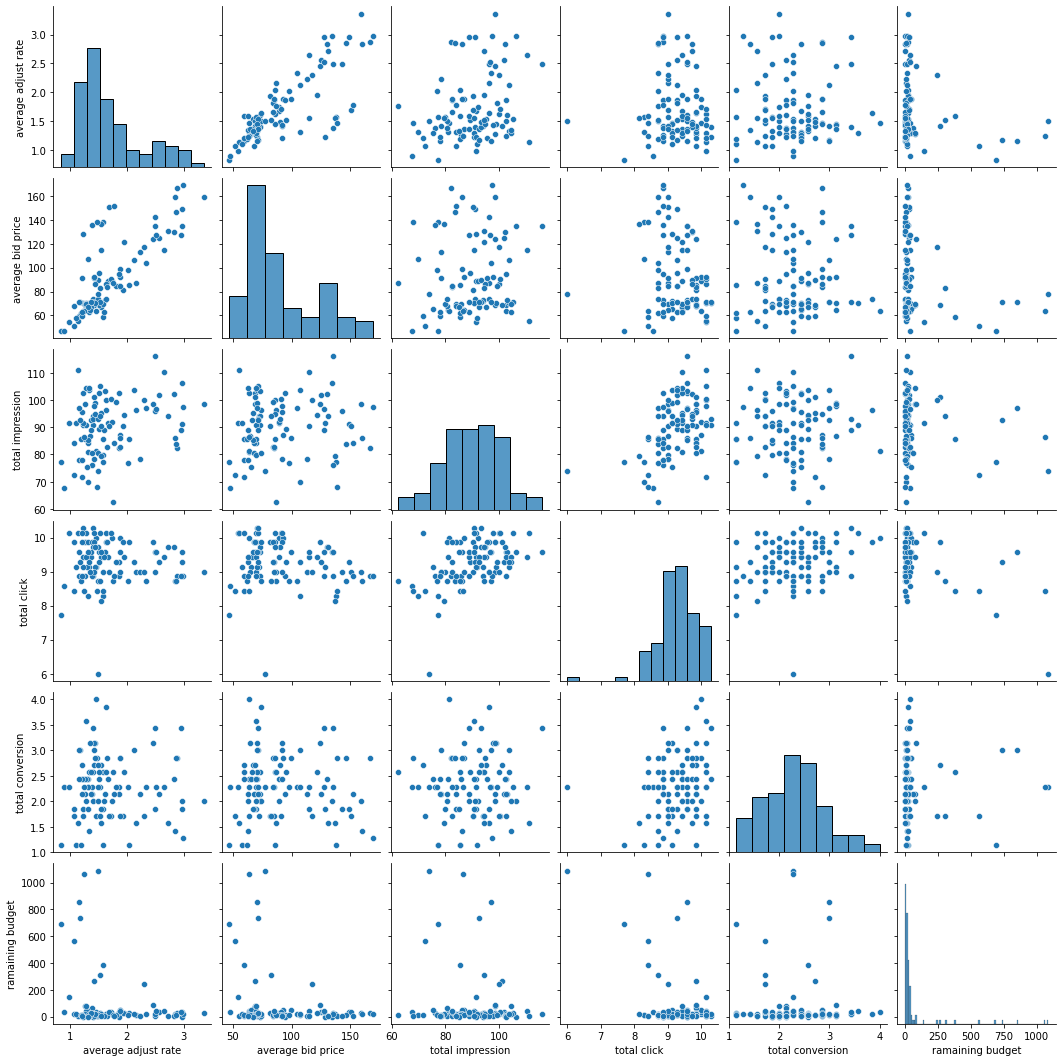

In [23]:
# we see a strong correlation between number of impression and click.
# However, large number of click does not necessarily lead to conversion.
sns.pairplot(df_[:100])

### 1.2. Softmax behavior policy
We can also use `DiscreteSoftmaxHead` to derive a stochastic behavior policy.

This algorithm uses Q function of the original algorithm, which estimates the value of given context and action pair (i.e., $(s, a)$) as $Q(s, a)$. \
Specifically, the behavior policy chooses actions stochastically as $\pi(a \mid s) = \frac{\exp(Q(s, a) / \tau)}{\sum_{a' \in A} \exp(Q(s, a') / \tau)}$, where $A$ indicates the set discrete actions and $\tau$ is a inverse temprature parameter.

In [24]:
# convert base ddqn policy into a stochastic data collection policy
from offlinegym.policy import DiscreteSoftmaxHead

behavior_policy = DiscreteSoftmaxHead(
    ddqn, 
    n_actions=env.action_space.n,
    tau=1.0,  # temperature parameter
    name="ddqn_softmax_tau_1.0",
    random_state=random_state,
)

In [25]:
# collect data
dataset = SyntheticDataset(
    env=env,
    behavior_policy=behavior_policy,
    random_state=random_state,
)
logged_dataset = dataset.obtain_trajectories(n_episodes=10000, obtain_info=True)

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

In [26]:
logged_dataset

{'size': 70000,
 'n_episodes': 10000,
 'step_per_episode': 7,
 'action_type': 'discrete',
 'n_actions': 10,
 'action_dim': None,
 'action_meaning': array([ 0.1       ,  0.16681005,  0.27825594,  0.46415888,  0.77426368,
         1.29154967,  2.15443469,  3.59381366,  5.9948425 , 10.        ]),
 'state_dim': 7,
 'state_keys': ['timestep',
  'remaining_budget',
  'budget_consumption_rate',
  'cost_per_mille_of_impression',
  'winning_rate',
  'reward',
  'adjust_rate'],
 'state': array([[0.00000000e+00, 3.00000000e+03, 9.29616093e-01, ...,
         1.83918812e-01, 2.00000000e+00, 2.76576693e-01],
        [1.00000000e+00, 1.94100000e+03, 3.53000000e-01, ...,
         9.95024876e-01, 6.00000000e+00, 2.15443469e+00],
        [2.00000000e+00, 1.94100000e+03, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 1.66810054e-01],
        ...,
        [4.00000000e+00, 3.40000000e+01, 9.58837772e-01, ...,
         8.26086957e-01, 2.00000000e+00, 5.99484250e+00],
        [5.00000000e+00, 

In [27]:
# check statistics of the dataset
# we see that the environment is highly stochstic and the reward is sparse
df = pd.DataFrame()
df['adjust rate'] = logged_dataset['state'][:, 6]
df['average bid price'] = logged_dataset['info']['average_bid_price']
df['impression'] = logged_dataset['info']['impression']
df['click'] = logged_dataset['info']['click']
df['conversion'] = logged_dataset['info']['conversion']
df['winning rate'] = logged_dataset['state'][:, 4]
df['click / impression'] = df['click'] / (df['impression'] + 1e-5)
df['conversion / click'] = df['conversion'] / (df['click'] + 1e-5)
df.describe()

,adjust rate,average bid price,impression,click,conversion,winning rate,click / impression,conversion / click
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,2.333361,126.021672,86.462443,8.695600,2.111271,0.487536,0.068400,0.140831
std,2.816095,149.378681,86.949984,9.299556,2.935704,0.417385,0.074613,0.183743
min,0.000004,3.995690,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.464159,21.641034,1.000000,0.000000,0.000000,0.023392,0.000000,0.000000
50%,1.291550,65.955182,52.000000,5.000000,1.000000,0.403372,0.076923,0.058823
75%,3.326956,175.376574,180.000000,17.000000,3.000000,0.991379,0.109244,0.249999
max,10.000000,553.283582,290.000000,40.000000,20.000000,1.000000,0.999997,0.999998


In [28]:
# aggeregate episodic statistics
df_ = pd.DataFrame()
df_['average adjust rate'] = logged_dataset['state'][:, 6].reshape(-1, 7).mean(axis=1)
df_['average bid price'] = logged_dataset['info']['average_bid_price'].reshape(-1, 7).mean(axis=1)
df_['total impression'] = logged_dataset['info']['impression'].reshape(-1, 7).mean(axis=1)
df_['total click'] = logged_dataset['info']['click'].reshape(-1, 7).mean(axis=1)
df_['total conversion'] = logged_dataset['info']['conversion'].reshape(-1, 7).mean(axis=1)
df_['ramaining budget'] = logged_dataset['state'][:,1].reshape(-1, 7)[:,6]
df_.describe()

,average adjust rate,average bid price,total impression,total click,total conversion,ramaining budget
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,2.333361,126.021672,86.462443,8.695600,2.111271,195.765100
std,1.016073,54.582573,11.609045,0.806371,0.544206,371.867899
min,0.460318,24.082391,23.857143,2.428571,0.000000,1.000000
25%,1.500677,82.316684,79.571429,8.428571,1.714286,13.000000
50%,2.229145,119.771335,86.714286,8.857143,2.142857,28.000000
75%,2.935453,159.051777,94.000000,9.142857,2.428571,141.000000
max,7.995729,450.926039,134.571429,10.857143,4.428571,2784.000000


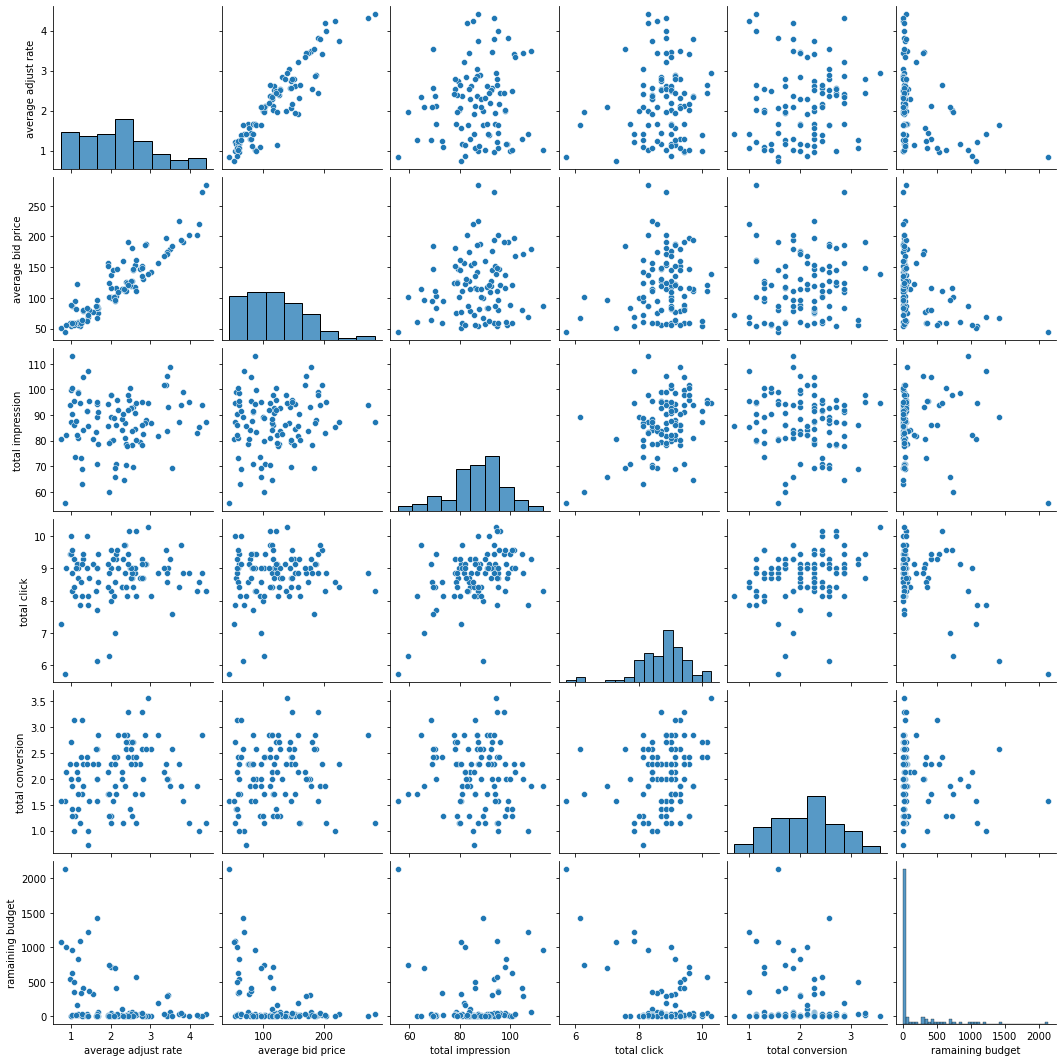

In [29]:
# seems softmax policy obtain impression more, but conversion less than the epsilon-greedy policy
sns.pairplot(df_[:100])

For offline RL and OPE procedures, please refer to [examples/quickstart/rtb_synthetic_discrete_basic.ipynb](https://github.com/negocia-inc/rtb_reinforcement_learing/blob/master/examples/quickstart/rtb_synthetic_discrete_basic.ipynb).\
For more advanced topic in OPE and OPS, please refer to [examples/quickstart/rtb_synthetic_discrete_advanced.ipynb](https://github.com/negocia-inc/rtb_reinforcement_learing/blob/ope/examples/quickstart/rtb_synthetic_discrete_advanced.ipynb).

## 2. Continuous Action Space
We also describe the case where the continuous behavior policy is used. \
Here, we first learn a base deterministic policy in a similar manner with discrete action case.

In [30]:
# setup discrete environment
env = CustomizedRTBEnv(
    original_env=RTBEnv(random_state=random_state),
    reward_predictor=LogisticRegression(),
    action_type="continuous",
)

In [31]:
# learn base deterministic policy for data collection
from d3rlpy.algos import SAC
from d3rlpy.models.encoders import VectorEncoderFactory
from d3rlpy.models.q_functions import MeanQFunctionFactory
from d3rlpy.online.buffers import ReplayBuffer

# model
sac = SAC(
    actor_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    critic_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    q_func_factory=MeanQFunctionFactory(),
    use_gpu=torch.cuda.is_available(),
    action_scaler=MinMaxActionScaler(
        minimum=env.action_space.low,   # 0.1
        maximum=env.action_space.high,  # 10
    ),
)
# setup replay buffer
buffer = ReplayBuffer(
    maxlen=10000,
    env=env,
)

In [32]:
# start training
# skip if there is a pre-trained model
sac.fit_online(
    env,
    buffer,
    eval_env=env,
    n_steps=100000,
    n_steps_per_epoch=1000,
)

2022-04-09 11:15.56 [info     ] Directory is created at d3rlpy_logs/SAC_online_20220409111556
2022-04-09 11:15.56 [debug    ] Fitting action scaler...       action_scler=min_max
2022-04-09 11:15.56 [debug    ] Building model...
2022-04-09 11:15.56 [debug    ] Model has been built.
2022-04-09 11:15.56 [info     ] Parameters are saved to d3rlpy_logs/SAC_online_20220409111556/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0003, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'batch_size': 256, 'critic_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense'

  1%|          | 990/100000 [00:06<13:41, 120.53it/s]

2022-04-09 11:16.02 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20220409111556/model_1000.pt
2022-04-09 11:16.02 [info     ] SAC_online_20220409111556: epoch=1 step=1000 epoch=1 metrics={'time_inference': 0.0006377546787261963, 'time_environment_step': 0.0007427801404680524, 'time_step': 0.006282774686813354, 'rollout_return': 9.632, 'time_sample_batch': 0.00028889755885705583, 'time_algorithm_update': 0.006677898692949827, 'temp_loss': -10.961644571184943, 'temp': 1.045743011855, 'critic_loss': 1841.1657134275963, 'actor_loss': 51.786305714867574, 'evaluation': 17.4} step=1000


  2%|▏         | 1986/100000 [00:14<13:11, 123.86it/s]

2022-04-09 11:16.11 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20220409111556/model_2000.pt
2022-04-09 11:16.11 [info     ] SAC_online_20220409111556: epoch=2 step=2000 epoch=2 metrics={'time_inference': 0.0006961240768432617, 'time_environment_step': 0.0008191010611397879, 'time_sample_batch': 0.0003098645210266113, 'time_algorithm_update': 0.0067094571590423585, 'temp_loss': -6.489599638938904, 'temp': 1.1796171805858613, 'critic_loss': 379.4209036102295, 'actor_loss': 32.59407086372376, 'time_step': 0.008515472888946534, 'rollout_return': 13.328, 'evaluation': 14.9} step=2000


  3%|▎         | 2998/100000 [00:22<11:25, 141.41it/s]

2022-04-09 11:16.19 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20220409111556/model_3000.pt
2022-04-09 11:16.19 [info     ] SAC_online_20220409111556: epoch=3 step=3000 epoch=3 metrics={'time_inference': 0.0006066951751708985, 'time_environment_step': 0.000749392100742885, 'time_sample_batch': 0.00028745794296264647, 'time_algorithm_update': 0.005960185527801514, 'temp_loss': -8.74756340765953, 'temp': 1.5083831205368041, 'critic_loss': 447.19692401123046, 'actor_loss': 35.06403802299499, 'time_step': 0.007584951400756836, 'rollout_return': 14.4, 'evaluation': 17.4} step=3000


  4%|▍         | 3996/100000 [00:38<29:22, 54.46it/s] 

2022-04-09 11:16.34 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20220409111556/model_4000.pt
2022-04-09 11:16.34 [info     ] SAC_online_20220409111556: epoch=4 step=4000 epoch=4 metrics={'time_inference': 0.0008270399570465088, 'time_environment_step': 0.0010617168971470425, 'time_sample_batch': 0.0003881678581237793, 'time_algorithm_update': 0.012400108575820922, 'temp_loss': -11.2248478140831, 'temp': 2.0685011109113693, 'critic_loss': 690.3408557128906, 'actor_loss': 43.4666028175354, 'time_step': 0.014643033742904663, 'rollout_return': 13.328, 'evaluation': 14.5} step=4000


  5%|▍         | 4993/100000 [00:56<26:50, 58.98it/s]

2022-04-09 11:16.52 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20220409111556/model_5000.pt
2022-04-09 11:16.52 [info     ] SAC_online_20220409111556: epoch=5 step=5000 epoch=5 metrics={'time_inference': 0.0009284052848815918, 'time_environment_step': 0.0011809975760323662, 'time_sample_batch': 0.00042735505104064944, 'time_algorithm_update': 0.014912474393844605, 'temp_loss': -16.17061550092697, 'temp': 2.9899697880744935, 'critic_loss': 1362.100633605957, 'actor_loss': 62.43448677825928, 'time_step': 0.01742340874671936, 'rollout_return': 13.392, 'evaluation': 13.3} step=5000


  6%|▌         | 5999/100000 [01:13<23:27, 66.81it/s]

2022-04-09 11:17.09 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20220409111556/model_6000.pt
2022-04-09 11:17.10 [info     ] SAC_online_20220409111556: epoch=6 step=6000 epoch=6 metrics={'time_inference': 0.0008619587421417236, 'time_environment_step': 0.0010896663665771484, 'time_sample_batch': 0.0004390254020690918, 'time_algorithm_update': 0.013669257879257202, 'temp_loss': -26.763021797180176, 'temp': 4.4395730407238005, 'critic_loss': 3133.5278800048827, 'actor_loss': 100.00735981750488, 'time_step': 0.01603337812423706, 'rollout_return': 13.424, 'evaluation': 14.5} step=6000


  7%|▋         | 6998/100000 [01:31<24:32, 63.14it/s]

2022-04-09 11:17.27 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20220409111556/model_7000.pt
2022-04-09 11:17.27 [info     ] SAC_online_20220409111556: epoch=7 step=7000 epoch=7 metrics={'time_inference': 0.0009389908313751221, 'time_environment_step': 0.0011526881626674108, 'time_sample_batch': 0.0004531996250152588, 'time_algorithm_update': 0.014044531106948853, 'temp_loss': -12.471063128948211, 'temp': 5.893570136547089, 'critic_loss': 2861.001380615234, 'actor_loss': 82.61835404205323, 'time_step': 0.01656543445587158, 'rollout_return': 14.544, 'evaluation': 12.8} step=7000


  8%|▊         | 7996/100000 [01:47<27:35, 55.56it/s]

2022-04-09 11:17.43 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20220409111556/model_8000.pt
2022-04-09 11:17.43 [info     ] SAC_online_20220409111556: epoch=8 step=8000 epoch=8 metrics={'time_inference': 0.0008760948181152344, 'time_environment_step': 0.0010808977399553571, 'time_sample_batch': 0.0004763786792755127, 'time_algorithm_update': 0.01271766209602356, 'temp_loss': -15.477869669914245, 'temp': 7.334007802009583, 'critic_loss': 4285.024900878906, 'actor_loss': 88.4688147354126, 'time_step': 0.015134848833084106, 'rollout_return': 15.2, 'evaluation': 13.6} step=8000


  9%|▉         | 8994/100000 [02:03<24:34, 61.70it/s]

2022-04-09 11:17.59 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20220409111556/model_9000.pt
2022-04-09 11:17.59 [info     ] SAC_online_20220409111556: epoch=9 step=9000 epoch=9 metrics={'time_inference': 0.0008386807441711425, 'time_environment_step': 0.0010767688751220704, 'time_sample_batch': 0.0004611649513244629, 'time_algorithm_update': 0.012689868927001953, 'temp_loss': -22.090433956623077, 'temp': 10.029499950408935, 'critic_loss': 8094.885828857422, 'actor_loss': 117.68232712554932, 'time_step': 0.015041407823562622, 'rollout_return': 14.72, 'evaluation': 15.1} step=9000


 10%|▉         | 9997/100000 [02:19<22:23, 66.99it/s]

2022-04-09 11:18.16 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20220409111556/model_10000.pt
2022-04-09 11:18.16 [info     ] SAC_online_20220409111556: epoch=10 step=10000 epoch=10 metrics={'time_inference': 0.0009237504005432128, 'time_environment_step': 0.0010852045331682478, 'time_sample_batch': 0.00045043516159057616, 'time_algorithm_update': 0.01324423885345459, 'temp_loss': -34.6374253988266, 'temp': 14.577790148735046, 'critic_loss': 17513.536268554686, 'actor_loss': 176.43276344299318, 'time_step': 0.015678884267807006, 'rollout_return': 14.608, 'evaluation': 16.9} step=10000


 11%|█         | 10994/100000 [02:37<23:21, 63.51it/s]

2022-04-09 11:18.33 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20220409111556/model_11000.pt
2022-04-09 11:18.34 [info     ] SAC_online_20220409111556: epoch=11 step=11000 epoch=11 metrics={'time_inference': 0.0009255118370056153, 'time_environment_step': 0.0011451590401785714, 'time_sample_batch': 0.00046515798568725583, 'time_algorithm_update': 0.01424171543121338, 'temp_loss': -52.573295694351195, 'temp': 21.37616294670105, 'critic_loss': 38706.380474609374, 'actor_loss': 266.1395970001221, 'time_step': 0.01675743007659912, 'rollout_return': 14.272, 'evaluation': 16.9} step=11000


 12%|█▏        | 11994/100000 [02:55<27:00, 54.30it/s]

2022-04-09 11:18.51 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20220409111556/model_12000.pt
2022-04-09 11:18.51 [info     ] SAC_online_20220409111556: epoch=12 step=12000 epoch=12 metrics={'time_inference': 0.0009034759998321533, 'time_environment_step': 0.0011685191563197545, 'time_sample_batch': 0.0004889731407165527, 'time_algorithm_update': 0.014080516576766967, 'temp_loss': -74.81793194198609, 'temp': 31.58872083091736, 'critic_loss': 81759.30035546875, 'actor_loss': 390.43604431152346, 'time_step': 0.016619508028030396, 'rollout_return': 14.592, 'evaluation': 12.9} step=12000


 13%|█▎        | 12995/100000 [03:12<22:19, 64.94it/s]

2022-04-09 11:19.08 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20220409111556/model_13000.pt
2022-04-09 11:19.09 [info     ] SAC_online_20220409111556: epoch=13 step=13000 epoch=13 metrics={'time_inference': 0.0009160144329071045, 'time_environment_step': 0.0011194613320486887, 'time_sample_batch': 0.0004753232002258301, 'time_algorithm_update': 0.013861554861068725, 'temp_loss': -115.16637645339966, 'temp': 46.553276954650876, 'critic_loss': 178133.735609375, 'actor_loss': 579.5689160461426, 'time_step': 0.0163611261844635, 'rollout_return': 14.776, 'evaluation': 15.1} step=13000


 14%|█▍        | 13997/100000 [03:29<23:31, 60.95it/s]

2022-04-09 11:19.25 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20220409111556/model_14000.pt
2022-04-09 11:19.25 [info     ] SAC_online_20220409111556: epoch=14 step=14000 epoch=14 metrics={'time_inference': 0.0009517514705657959, 'time_environment_step': 0.0011368056706019811, 'time_sample_batch': 0.0004761245250701904, 'time_algorithm_update': 0.013251454353332519, 'temp_loss': -169.07993209266664, 'temp': 68.57791458129883, 'critic_loss': 379336.1669453125, 'actor_loss': 852.622471862793, 'time_step': 0.015808295726776122, 'rollout_return': 14.816, 'evaluation': 17.0} step=14000


 15%|█▍        | 14999/100000 [03:45<21:56, 64.58it/s]

2022-04-09 11:19.42 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20220409111556/model_15000.pt
2022-04-09 11:19.42 [info     ] SAC_online_20220409111556: epoch=15 step=15000 epoch=15 metrics={'time_inference': 0.0009152591228485107, 'time_environment_step': 0.0011085314069475447, 'time_sample_batch': 0.0004795026779174805, 'time_algorithm_update': 0.013002485275268554, 'temp_loss': -260.9056119709015, 'temp': 101.44598119354248, 'critic_loss': 831194.257828125, 'actor_loss': 1259.427568359375, 'time_step': 0.015479050636291503, 'rollout_return': 14.976, 'evaluation': 14.4} step=15000


 16%|█▌        | 15995/100000 [04:02<21:57, 63.76it/s]

2022-04-09 11:19.58 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20220409111556/model_16000.pt
2022-04-09 11:19.58 [info     ] SAC_online_20220409111556: epoch=16 step=16000 epoch=16 metrics={'time_inference': 0.0009148645401000976, 'time_environment_step': 0.0011091027941022601, 'time_sample_batch': 0.0004707651138305664, 'time_algorithm_update': 0.013149821281433105, 'temp_loss': -395.5895173034668, 'temp': 149.80688439941406, 'critic_loss': 1895623.374125, 'actor_loss': 1902.8694931640625, 'time_step': 0.0156251859664917, 'rollout_return': 14.504, 'evaluation': 14.7} step=16000


 17%|█▋        | 16995/100000 [04:21<25:30, 54.22it/s]

2022-04-09 11:20.18 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20220409111556/model_17000.pt
2022-04-09 11:20.18 [info     ] SAC_online_20220409111556: epoch=17 step=17000 epoch=17 metrics={'time_inference': 0.0009970512390136718, 'time_environment_step': 0.0011719474792480469, 'time_sample_batch': 0.00048139023780822753, 'time_algorithm_update': 0.015865698337554933, 'temp_loss': -574.3502059326172, 'temp': 222.14041804504396, 'critic_loss': 4115612.8125, 'actor_loss': 2795.765621826172, 'time_step': 0.018501423120498656, 'rollout_return': 14.712, 'evaluation': 14.6} step=17000


 18%|█▊        | 17993/100000 [04:38<19:59, 68.35it/s]

2022-04-09 11:20.34 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20220409111556/model_18000.pt
2022-04-09 11:20.34 [info     ] SAC_online_20220409111556: epoch=18 step=18000 epoch=18 metrics={'time_inference': 0.0009447360038757325, 'time_environment_step': 0.0011738482883998326, 'time_sample_batch': 0.0004828071594238281, 'time_algorithm_update': 0.013040958166122437, 'temp_loss': -865.4739404296874, 'temp': 329.01642333984375, 'critic_loss': 8872875.93175, 'actor_loss': 4123.372868652344, 'time_step': 0.015635340929031374, 'rollout_return': 14.688, 'evaluation': 12.8} step=18000


 19%|█▉        | 18993/100000 [04:54<17:36, 76.65it/s]

2022-04-09 11:20.50 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20220409111556/model_19000.pt
2022-04-09 11:20.50 [info     ] SAC_online_20220409111556: epoch=19 step=19000 epoch=19 metrics={'time_inference': 0.0008836162090301514, 'time_environment_step': 0.001124265398297991, 'time_sample_batch': 0.00045131778717041014, 'time_algorithm_update': 0.012561494827270508, 'temp_loss': -1258.5934583282472, 'temp': 486.609543548584, 'critic_loss': 19653453.873, 'actor_loss': 6118.1367729492185, 'time_step': 0.015005606651306153, 'rollout_return': 14.616, 'evaluation': 13.8} step=19000


 20%|█▉        | 19997/100000 [05:09<18:09, 73.46it/s]

2022-04-09 11:21.06 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20220409111556/model_20000.pt
2022-04-09 11:21.06 [info     ] SAC_online_20220409111556: epoch=20 step=20000 epoch=20 metrics={'time_inference': 0.0008916161060333252, 'time_environment_step': 0.001095813206263951, 'time_sample_batch': 0.00047219300270080565, 'time_algorithm_update': 0.01236013913154602, 'temp_loss': -1901.685385131836, 'temp': 721.447663269043, 'critic_loss': 43052017.118, 'actor_loss': 9049.06284423828, 'time_step': 0.014797556400299072, 'rollout_return': 14.712, 'evaluation': 13.6} step=20000


 21%|██        | 20993/100000 [05:24<19:24, 67.85it/s]

2022-04-09 11:21.21 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20220409111556/model_21000.pt
2022-04-09 11:21.21 [info     ] SAC_online_20220409111556: epoch=21 step=21000 epoch=21 metrics={'time_inference': 0.0008916642665863037, 'time_environment_step': 0.0010812061854771206, 'time_sample_batch': 0.00045386600494384767, 'time_algorithm_update': 0.01185887336730957, 'temp_loss': -2789.6334072265627, 'temp': 1067.9554543457032, 'critic_loss': 93610920.232, 'actor_loss': 13249.6363203125, 'time_step': 0.014274874210357665, 'rollout_return': 15.016, 'evaluation': 14.1} step=21000


 22%|██▏       | 21994/100000 [05:39<19:49, 65.60it/s]

2022-04-09 11:21.36 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20220409111556/model_22000.pt
2022-04-09 11:21.36 [info     ] SAC_online_20220409111556: epoch=22 step=22000 epoch=22 metrics={'time_inference': 0.0008533546924591064, 'time_environment_step': 0.0010981854030064173, 'time_sample_batch': 0.00044857907295227053, 'time_algorithm_update': 0.011862033843994141, 'temp_loss': -4145.537498779297, 'temp': 1582.3929127197266, 'critic_loss': 208504374.168, 'actor_loss': 19735.968913085937, 'time_step': 0.014237595319747925, 'rollout_return': 14.792, 'evaluation': 14.4} step=22000


 23%|██▎       | 22999/100000 [05:55<19:49, 64.71it/s]

2022-04-09 11:21.51 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20220409111556/model_23000.pt
2022-04-09 11:21.51 [info     ] SAC_online_20220409111556: epoch=23 step=23000 epoch=23 metrics={'time_inference': 0.0009038617610931396, 'time_environment_step': 0.0011669837406703405, 'time_sample_batch': 0.0004647324085235596, 'time_algorithm_update': 0.012229698181152344, 'temp_loss': -6200.76247265625, 'temp': 2346.7591018066405, 'critic_loss': 452322333.936, 'actor_loss': 28979.57076953125, 'time_step': 0.01473454236984253, 'rollout_return': 14.168, 'evaluation': 14.5} step=23000


 24%|██▍       | 23991/100000 [06:09<18:30, 68.42it/s]

2022-04-09 11:22.06 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20220409111556/model_24000.pt
2022-04-09 11:22.06 [info     ] SAC_online_20220409111556: epoch=24 step=24000 epoch=24 metrics={'time_inference': 0.0008418540954589844, 'time_environment_step': 0.0011027472359793527, 'time_sample_batch': 0.000456118106842041, 'time_algorithm_update': 0.011419321775436402, 'temp_loss': -9156.55540258789, 'temp': 3478.7348837890627, 'critic_loss': 1004170737.664, 'actor_loss': 43064.44165234375, 'time_step': 0.013796554327011108, 'rollout_return': 14.656, 'evaluation': 14.9} step=24000


 25%|██▍       | 24992/100000 [06:25<17:56, 69.69it/s]

2022-04-09 11:22.21 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20220409111556/model_25000.pt
2022-04-09 11:22.21 [info     ] SAC_online_20220409111556: epoch=25 step=25000 epoch=25 metrics={'time_inference': 0.0008859057426452636, 'time_environment_step': 0.0011069466727120535, 'time_sample_batch': 0.00046121525764465334, 'time_algorithm_update': 0.012241990566253661, 'temp_loss': -13247.580948120118, 'temp': 5122.643475585937, 'critic_loss': 2151449179.008, 'actor_loss': 62269.52894921875, 'time_step': 0.014666413068771362, 'rollout_return': 14.976, 'evaluation': 15.1} step=25000


 26%|██▌       | 25996/100000 [06:39<11:24, 108.10it/s]

2022-04-09 11:22.35 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20220409111556/model_26000.pt
2022-04-09 11:22.35 [info     ] SAC_online_20220409111556: epoch=26 step=26000 epoch=26 metrics={'time_inference': 0.0008601696491241455, 'time_environment_step': 0.0010453455788748604, 'time_sample_batch': 0.00045554995536804197, 'time_algorithm_update': 0.01072726535797119, 'temp_loss': -19857.223408203125, 'temp': 7580.399317382812, 'critic_loss': 4693619440.384, 'actor_loss': 92672.0486328125, 'time_step': 0.013064694404602051, 'rollout_return': 14.272, 'evaluation': 14.3} step=26000


 27%|██▋       | 26992/100000 [06:47<09:08, 133.06it/s]

2022-04-09 11:22.43 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20220409111556/model_27000.pt
2022-04-09 11:22.43 [info     ] SAC_online_20220409111556: epoch=27 step=27000 epoch=27 metrics={'time_inference': 0.0006334574222564697, 'time_environment_step': 0.0007736097063337054, 'time_sample_batch': 0.00033475828170776367, 'time_algorithm_update': 0.006210534572601318, 'temp_loss': 9537.95892604065, 'temp': 8671.502772460937, 'critic_loss': 938419323.256, 'actor_loss': 33107.867119140625, 'time_step': 0.007936249732971192, 'rollout_return': 15.008, 'evaluation': 14.4} step=27000


 28%|██▊       | 27993/100000 [07:00<19:39, 61.04it/s] 

2022-04-09 11:22.56 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20220409111556/model_28000.pt
2022-04-09 11:22.56 [info     ] SAC_online_20220409111556: epoch=28 step=28000 epoch=28 metrics={'time_inference': 0.0007415792942047119, 'time_environment_step': 0.0009828897203717913, 'time_sample_batch': 0.0003911309242248535, 'time_algorithm_update': 0.010363212823867797, 'temp_loss': 10816.17503125, 'temp': 6867.9194111328125, 'critic_loss': 76357221.984, 'actor_loss': -2660.6230172080996, 'time_step': 0.012451732158660888, 'rollout_return': 14.416, 'evaluation': 12.0} step=28000


 29%|██▉       | 28996/100000 [07:16<18:04, 65.46it/s]

2022-04-09 11:23.12 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20220409111556/model_29000.pt
2022-04-09 11:23.12 [info     ] SAC_online_20220409111556: epoch=29 step=29000 epoch=29 metrics={'time_inference': 0.0008902997970581055, 'time_environment_step': 0.001064976828438895, 'time_sample_batch': 0.0004589023590087891, 'time_algorithm_update': 0.01309695291519165, 'temp_loss': 8704.562942382812, 'temp': 5443.422945800781, 'critic_loss': 22390205.005, 'actor_loss': -9557.279902832031, 'time_step': 0.015480084419250488, 'rollout_return': 14.864, 'evaluation': 14.1} step=29000


 30%|██▉       | 29995/100000 [07:32<23:41, 49.24it/s]

2022-04-09 11:23.28 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20220409111556/model_30000.pt
2022-04-09 11:23.28 [info     ] SAC_online_20220409111556: epoch=30 step=30000 epoch=30 metrics={'time_inference': 0.000902601957321167, 'time_environment_step': 0.0010799647739955357, 'time_sample_batch': 0.00046027493476867673, 'time_algorithm_update': 0.01260338282585144, 'temp_loss': 6963.125341796875, 'temp': 4330.87964819336, 'critic_loss': 14071059.238, 'actor_loss': -9314.40773828125, 'time_step': 0.015020276069641113, 'rollout_return': 14.728, 'evaluation': 15.9} step=30000


 31%|███       | 30994/100000 [07:49<22:28, 51.19it/s]

2022-04-09 11:23.46 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20220409111556/model_31000.pt
2022-04-09 11:23.46 [info     ] SAC_online_20220409111556: epoch=31 step=31000 epoch=31 metrics={'time_inference': 0.000943972110748291, 'time_environment_step': 0.0011396236419677734, 'time_sample_batch': 0.0004484677314758301, 'time_algorithm_update': 0.013883384704589843, 'temp_loss': 5516.865821533203, 'temp': 3453.856957519531, 'critic_loss': 9516432.60375, 'actor_loss': -7735.64440625, 'time_step': 0.016382171630859376, 'rollout_return': 14.808, 'evaluation': 14.5} step=31000


 32%|███▏      | 31995/100000 [08:07<30:33, 37.09it/s]

2022-04-09 11:24.04 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20220409111556/model_32000.pt
2022-04-09 11:24.04 [info     ] SAC_online_20220409111556: epoch=32 step=32000 epoch=32 metrics={'time_inference': 0.0009665725231170655, 'time_environment_step': 0.0011557415553501674, 'time_sample_batch': 0.0004650180339813232, 'time_algorithm_update': 0.014450822830200195, 'temp_loss': 4441.076841796875, 'temp': 2759.2954533691404, 'critic_loss': 5703944.7055, 'actor_loss': -6323.465449707031, 'time_step': 0.0170063271522522, 'rollout_return': 15.288, 'evaluation': 14.1} step=32000


 33%|███▎      | 32998/100000 [08:26<16:00, 69.75it/s]  

2022-04-09 11:24.22 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20220409111556/model_33000.pt
2022-04-09 11:24.22 [info     ] SAC_online_20220409111556: epoch=33 step=33000 epoch=33 metrics={'time_inference': 0.0009356222152709961, 'time_environment_step': 0.001096736090523856, 'time_sample_batch': 0.0004617905616760254, 'time_algorithm_update': 0.015041068077087402, 'temp_loss': 3509.148709350586, 'temp': 2208.696416870117, 'critic_loss': 4102814.2945, 'actor_loss': -4934.198522949218, 'time_step': 0.017529073238372803, 'rollout_return': 14.512, 'evaluation': 14.8} step=33000


 34%|███▍      | 33996/100000 [08:44<16:00, 68.74it/s]

2022-04-09 11:24.40 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20220409111556/model_34000.pt
2022-04-09 11:24.40 [info     ] SAC_online_20220409111556: epoch=34 step=34000 epoch=34 metrics={'time_inference': 0.0009513485431671142, 'time_environment_step': 0.0011138520921979633, 'time_sample_batch': 0.00046636605262756345, 'time_algorithm_update': 0.01448054575920105, 'temp_loss': 2806.5232442626952, 'temp': 1767.4333337402343, 'critic_loss': 2641040.446125, 'actor_loss': -3908.937841064453, 'time_step': 0.01698767566680908, 'rollout_return': 15.4, 'evaluation': 14.8} step=34000


 35%|███▍      | 34991/100000 [08:55<09:39, 112.12it/s]

2022-04-09 11:24.52 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20220409111556/model_35000.pt
2022-04-09 11:24.52 [info     ] SAC_online_20220409111556: epoch=35 step=35000 epoch=35 metrics={'time_inference': 0.0007959675788879395, 'time_environment_step': 0.0009255022321428572, 'time_sample_batch': 0.0003886873722076416, 'time_algorithm_update': 0.008905547380447387, 'temp_loss': 2248.8664738159177, 'temp': 1412.2149794921875, 'critic_loss': 1550540.165625, 'actor_loss': -3143.3509326171875, 'time_step': 0.01100173258781433, 'rollout_return': 14.584, 'evaluation': 14.1} step=35000


 36%|███▌      | 35999/100000 [09:03<07:56, 134.24it/s]

2022-04-09 11:25.00 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20220409111556/model_36000.pt
2022-04-09 11:25.00 [info     ] SAC_online_20220409111556: epoch=36 step=36000 epoch=36 metrics={'time_inference': 0.0006336567401885986, 'time_environment_step': 0.0007788497379847936, 'time_sample_batch': 0.00033678126335144045, 'time_algorithm_update': 0.006214457511901856, 'temp_loss': 1807.7902908935546, 'temp': 1129.387358581543, 'critic_loss': 934153.42909375, 'actor_loss': -2528.058827392578, 'time_step': 0.007947731733322144, 'rollout_return': 15.384, 'evaluation': 14.2} step=36000


 37%|███▋      | 36986/100000 [09:11<07:45, 135.41it/s]

2022-04-09 11:25.07 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20220409111556/model_37000.pt
2022-04-09 11:25.07 [info     ] SAC_online_20220409111556: epoch=37 step=37000 epoch=37 metrics={'time_inference': 0.0006025104522705078, 'time_environment_step': 0.0007339741843087333, 'time_sample_batch': 0.0003208460807800293, 'time_algorithm_update': 0.005937203168869019, 'temp_loss': 1451.2294179077148, 'temp': 903.8122744750976, 'critic_loss': 577409.702109375, 'actor_loss': -2008.8598876953124, 'time_step': 0.007577061176300049, 'rollout_return': 14.072, 'evaluation': 15.9} step=37000


 38%|███▊      | 37994/100000 [09:19<07:43, 133.77it/s]

2022-04-09 11:25.15 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20220409111556/model_38000.pt
2022-04-09 11:25.15 [info     ] SAC_online_20220409111556: epoch=38 step=38000 epoch=38 metrics={'time_inference': 0.000596534013748169, 'time_environment_step': 0.000729271480015346, 'time_sample_batch': 0.00032045769691467285, 'time_algorithm_update': 0.005888372421264648, 'temp_loss': 1156.8331799926757, 'temp': 722.4474175415039, 'critic_loss': 366464.385109375, 'actor_loss': -1598.4536772460938, 'time_step': 0.007517367124557495, 'rollout_return': 14.448, 'evaluation': 13.9} step=38000


 39%|███▉      | 38996/100000 [09:27<07:42, 132.02it/s]

2022-04-09 11:25.23 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20220409111556/model_39000.pt
2022-04-09 11:25.23 [info     ] SAC_online_20220409111556: epoch=39 step=39000 epoch=39 metrics={'time_inference': 0.0005923783779144287, 'time_environment_step': 0.0007232221875871931, 'time_sample_batch': 0.00031569266319274905, 'time_algorithm_update': 0.005853752136230469, 'temp_loss': 926.5430256958008, 'temp': 577.5792973022461, 'critic_loss': 251761.5906484375, 'actor_loss': -1285.183727294922, 'time_step': 0.007467597723007202, 'rollout_return': 14.448, 'evaluation': 15.3} step=39000


 40%|███▉      | 39996/100000 [09:34<07:45, 128.81it/s]

2022-04-09 11:25.31 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20220409111556/model_40000.pt
2022-04-09 11:25.31 [info     ] SAC_online_20220409111556: epoch=40 step=40000 epoch=40 metrics={'time_inference': 0.0005985920429229737, 'time_environment_step': 0.0007329093388148717, 'time_sample_batch': 0.0003196418285369873, 'time_algorithm_update': 0.005925312757492065, 'temp_loss': 740.7510019836426, 'temp': 461.9549707641602, 'critic_loss': 152424.3466171875, 'actor_loss': -1035.631974609375, 'time_step': 0.0075578374862670895, 'rollout_return': 14.736, 'evaluation': 14.6} step=40000


 41%|████      | 40996/100000 [09:42<07:38, 128.72it/s]

2022-04-09 11:25.38 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20220409111556/model_41000.pt
2022-04-09 11:25.38 [info     ] SAC_online_20220409111556: epoch=41 step=41000 epoch=41 metrics={'time_inference': 0.0006066057682037354, 'time_environment_step': 0.0007409651620047433, 'time_sample_batch': 0.0003249156475067139, 'time_algorithm_update': 0.006038325071334839, 'temp_loss': 590.0616808166504, 'temp': 369.5126416015625, 'critic_loss': 100826.87563671875, 'actor_loss': -825.913344543457, 'time_step': 0.007694433450698853, 'rollout_return': 14.576, 'evaluation': 16.1} step=41000


 42%|████▏     | 41986/100000 [09:51<07:19, 131.86it/s]

2022-04-09 11:25.47 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20220409111556/model_42000.pt
2022-04-09 11:25.47 [info     ] SAC_online_20220409111556: epoch=42 step=42000 epoch=42 metrics={'time_inference': 0.0006904842853546143, 'time_environment_step': 0.000824932370867048, 'time_sample_batch': 0.0003534541130065918, 'time_algorithm_update': 0.006670403242111206, 'temp_loss': 474.2578393249512, 'temp': 295.4335157775879, 'critic_loss': 61504.38432226562, 'actor_loss': -667.9797784423828, 'time_step': 0.008525691986083984, 'rollout_return': 14.616, 'evaluation': 14.8} step=42000


 43%|████▎     | 42989/100000 [09:59<07:27, 127.38it/s]

2022-04-09 11:25.55 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20220409111556/model_43000.pt
2022-04-09 11:25.55 [info     ] SAC_online_20220409111556: epoch=43 step=43000 epoch=43 metrics={'time_inference': 0.0006469137668609619, 'time_environment_step': 0.0007769058772495815, 'time_sample_batch': 0.00033784961700439455, 'time_algorithm_update': 0.006337219715118408, 'temp_loss': 380.78134652709963, 'temp': 236.2145867614746, 'critic_loss': 38024.084087890624, 'actor_loss': -537.9969457397461, 'time_step': 0.008084086894989014, 'rollout_return': 14.544, 'evaluation': 15.1} step=43000


 44%|████▍     | 43989/100000 [10:07<06:45, 138.27it/s]

2022-04-09 11:26.04 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20220409111556/model_44000.pt
2022-04-09 11:26.04 [info     ] SAC_online_20220409111556: epoch=44 step=44000 epoch=44 metrics={'time_inference': 0.0006400911808013916, 'time_environment_step': 0.0007773331233433315, 'time_sample_batch': 0.0003354752063751221, 'time_algorithm_update': 0.00623665738105774, 'temp_loss': 301.4419396057129, 'temp': 189.07434490966796, 'critic_loss': 28923.470174804686, 'actor_loss': -415.9072940826416, 'time_step': 0.007973381042480469, 'rollout_return': 14.616, 'evaluation': 15.9} step=44000


 45%|████▍     | 44996/100000 [10:17<06:43, 136.40it/s]

2022-04-09 11:26.13 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20220409111556/model_45000.pt
2022-04-09 11:26.13 [info     ] SAC_online_20220409111556: epoch=45 step=45000 epoch=45 metrics={'time_inference': 0.0007495715618133545, 'time_environment_step': 0.0008804517473493304, 'time_sample_batch': 0.00037702298164367674, 'time_algorithm_update': 0.007527443885803222, 'temp_loss': 241.51834765625, 'temp': 151.19935733032227, 'critic_loss': 17250.10953613281, 'actor_loss': -334.050865814209, 'time_step': 0.009521728992462158, 'rollout_return': 14.584, 'evaluation': 14.0} step=45000


 46%|████▌     | 45993/100000 [10:26<07:56, 113.24it/s]

2022-04-09 11:26.22 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20220409111556/model_46000.pt
2022-04-09 11:26.22 [info     ] SAC_online_20220409111556: epoch=46 step=46000 epoch=46 metrics={'time_inference': 0.0006758749485015869, 'time_environment_step': 0.000817643574305943, 'time_sample_batch': 0.0003511199951171875, 'time_algorithm_update': 0.006546682357788086, 'temp_loss': 194.0100690460205, 'temp': 121.00323628234864, 'critic_loss': 12118.868538085937, 'actor_loss': -265.4314434814453, 'time_step': 0.008375799894332885, 'rollout_return': 14.744, 'evaluation': 15.4} step=46000


 47%|████▋     | 46991/100000 [10:34<07:55, 111.43it/s]

2022-04-09 11:26.30 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20220409111556/model_47000.pt
2022-04-09 11:26.30 [info     ] SAC_online_20220409111556: epoch=47 step=47000 epoch=47 metrics={'time_inference': 0.000652883768081665, 'time_environment_step': 0.0007971343994140625, 'time_sample_batch': 0.0003401951789855957, 'time_algorithm_update': 0.006331425905227661, 'temp_loss': 154.3027476348877, 'temp': 96.78353594207763, 'critic_loss': 8946.187103027343, 'actor_loss': -208.43262888336182, 'time_step': 0.00810973072052002, 'rollout_return': 14.016, 'evaluation': 12.7} step=47000


 48%|████▊     | 47997/100000 [10:43<08:36, 100.73it/s]

2022-04-09 11:26.39 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20220409111556/model_48000.pt
2022-04-09 11:26.39 [info     ] SAC_online_20220409111556: epoch=48 step=48000 epoch=48 metrics={'time_inference': 0.0007393419742584229, 'time_environment_step': 0.0008784035273960659, 'time_sample_batch': 0.000372467041015625, 'time_algorithm_update': 0.007050102233886719, 'temp_loss': 123.51295323944092, 'temp': 77.46355075836182, 'critic_loss': 6287.64493774414, 'actor_loss': -160.4726078567505, 'time_step': 0.0090290789604187, 'rollout_return': 14.416, 'evaluation': 15.0} step=48000


 49%|████▉     | 48990/100000 [10:52<06:42, 126.64it/s]

2022-04-09 11:26.49 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20220409111556/model_49000.pt
2022-04-09 11:26.49 [info     ] SAC_online_20220409111556: epoch=49 step=49000 epoch=49 metrics={'time_inference': 0.0007160365581512451, 'time_environment_step': 0.0008568665640694754, 'time_sample_batch': 0.00037321281433105467, 'time_algorithm_update': 0.007028885841369629, 'temp_loss': 99.39643968963622, 'temp': 61.91905840682983, 'critic_loss': 4203.074337158203, 'actor_loss': -126.27087562942505, 'time_step': 0.008960124254226685, 'rollout_return': 13.792, 'evaluation': 14.3} step=49000


 50%|████▉     | 49995/100000 [11:01<06:33, 126.93it/s]

2022-04-09 11:26.57 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20220409111556/model_50000.pt
2022-04-09 11:26.57 [info     ] SAC_online_20220409111556: epoch=50 step=50000 epoch=50 metrics={'time_inference': 0.0006657414436340332, 'time_environment_step': 0.0008094850267682756, 'time_sample_batch': 0.0003494579792022705, 'time_algorithm_update': 0.006540415525436402, 'temp_loss': 78.5515235118866, 'temp': 49.54168711853028, 'critic_loss': 3427.273808349609, 'actor_loss': -94.49367799699307, 'time_step': 0.008348299980163574, 'rollout_return': 14.272, 'evaluation': 16.9} step=50000


 51%|█████     | 50998/100000 [11:09<07:09, 114.08it/s]

2022-04-09 11:27.05 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20220409111556/model_51000.pt
2022-04-09 11:27.05 [info     ] SAC_online_20220409111556: epoch=51 step=51000 epoch=51 metrics={'time_inference': 0.0006486380100250244, 'time_environment_step': 0.0007857469831194197, 'time_sample_batch': 0.0003409216403961182, 'time_algorithm_update': 0.0063066773414611815, 'temp_loss': 62.13270549583435, 'temp': 39.69220030212402, 'critic_loss': 2687.780852050781, 'actor_loss': -68.93883433175087, 'time_step': 0.008066896438598634, 'rollout_return': 14.176, 'evaluation': 14.5} step=51000


 52%|█████▏    | 51990/100000 [11:17<06:23, 125.16it/s]

2022-04-09 11:27.13 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20220409111556/model_52000.pt
2022-04-09 11:27.13 [info     ] SAC_online_20220409111556: epoch=52 step=52000 epoch=52 metrics={'time_inference': 0.0006026935577392578, 'time_environment_step': 0.0007359341212681362, 'time_sample_batch': 0.0003226437568664551, 'time_algorithm_update': 0.005974915027618408, 'temp_loss': 50.83622465324402, 'temp': 31.790446577072142, 'critic_loss': 1834.002810119629, 'actor_loss': -53.77538102126122, 'time_step': 0.007618830680847168, 'rollout_return': 14.832, 'evaluation': 15.4} step=52000


 53%|█████▎    | 52995/100000 [11:25<06:13, 125.89it/s]

2022-04-09 11:27.21 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20220409111556/model_53000.pt
2022-04-09 11:27.21 [info     ] SAC_online_20220409111556: epoch=53 step=53000 epoch=53 metrics={'time_inference': 0.0006084856986999512, 'time_environment_step': 0.0007505217960902623, 'time_sample_batch': 0.00032623863220214845, 'time_algorithm_update': 0.006026276588439941, 'temp_loss': 40.55497910881042, 'temp': 25.387468980789183, 'critic_loss': 1502.5225330810547, 'actor_loss': -40.457270301818845, 'time_step': 0.007694106817245483, 'rollout_return': 14.176, 'evaluation': 16.7} step=53000


 54%|█████▍    | 53988/100000 [11:33<06:24, 119.59it/s]

2022-04-09 11:27.29 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20220409111556/model_54000.pt
2022-04-09 11:27.29 [info     ] SAC_online_20220409111556: epoch=54 step=54000 epoch=54 metrics={'time_inference': 0.0006556506156921387, 'time_environment_step': 0.000798586164202009, 'time_sample_batch': 0.0003457503318786621, 'time_algorithm_update': 0.0064154000282287595, 'temp_loss': 32.518462043762206, 'temp': 20.28511573410034, 'critic_loss': 1251.0899201049804, 'actor_loss': -29.566934987038373, 'time_step': 0.008200474977493287, 'rollout_return': 14.432, 'evaluation': 14.3} step=54000


 55%|█████▍    | 54996/100000 [11:42<05:49, 128.89it/s]

2022-04-09 11:27.38 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20220409111556/model_55000.pt
2022-04-09 11:27.38 [info     ] SAC_online_20220409111556: epoch=55 step=55000 epoch=55 metrics={'time_inference': 0.0006913573741912842, 'time_environment_step': 0.000831653322492327, 'time_sample_batch': 0.00035550618171691897, 'time_algorithm_update': 0.006697816133499145, 'temp_loss': 25.587394529342653, 'temp': 16.23430167388916, 'critic_loss': 1134.7554873046874, 'actor_loss': -19.068053464651108, 'time_step': 0.008561407804489135, 'rollout_return': 14.672, 'evaluation': 15.1} step=55000


 56%|█████▌    | 55995/100000 [11:50<06:47, 108.06it/s]

2022-04-09 11:27.46 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20220409111556/model_56000.pt
2022-04-09 11:27.47 [info     ] SAC_online_20220409111556: epoch=56 step=56000 epoch=56 metrics={'time_inference': 0.0006402742862701416, 'time_environment_step': 0.0007779609135219029, 'time_sample_batch': 0.0003379001617431641, 'time_algorithm_update': 0.006300145864486694, 'temp_loss': 20.738065825462343, 'temp': 12.989954033851623, 'critic_loss': 918.3277565307617, 'actor_loss': -12.163284558415413, 'time_step': 0.008040426015853882, 'rollout_return': 15.096, 'evaluation': 14.6} step=56000


 57%|█████▋    | 56990/100000 [12:00<06:32, 109.70it/s]

2022-04-09 11:27.57 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20220409111556/model_57000.pt
2022-04-09 11:27.57 [info     ] SAC_online_20220409111556: epoch=57 step=57000 epoch=57 metrics={'time_inference': 0.0008182306289672851, 'time_environment_step': 0.0009660636356898717, 'time_sample_batch': 0.0003958616256713867, 'time_algorithm_update': 0.00775308084487915, 'temp_loss': 16.338720425605775, 'temp': 10.399581929206848, 'critic_loss': 931.6998048095703, 'actor_loss': -5.119575778808445, 'time_step': 0.009915420532226563, 'rollout_return': 14.696, 'evaluation': 16.5} step=57000


 58%|█████▊    | 57995/100000 [12:09<05:47, 120.95it/s]

2022-04-09 11:28.05 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20220409111556/model_58000.pt
2022-04-09 11:28.05 [info     ] SAC_online_20220409111556: epoch=58 step=58000 epoch=58 metrics={'time_inference': 0.0006931252479553222, 'time_environment_step': 0.0008357320513044085, 'time_sample_batch': 0.0003565633296966553, 'time_algorithm_update': 0.00669920802116394, 'temp_loss': 12.661801711380482, 'temp': 8.355416110515595, 'critic_loss': 782.4698296508789, 'actor_loss': -1.02716332975775, 'time_step': 0.008569979906082154, 'rollout_return': 14.424, 'evaluation': 13.9} step=58000


 59%|█████▉    | 58988/100000 [12:17<05:10, 132.01it/s]

2022-04-09 11:28.14 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20220409111556/model_59000.pt
2022-04-09 11:28.14 [info     ] SAC_online_20220409111556: epoch=59 step=59000 epoch=59 metrics={'time_inference': 0.0006550610065460205, 'time_environment_step': 0.0007682993752615793, 'time_sample_batch': 0.00033678507804870604, 'time_algorithm_update': 0.006238638877868652, 'temp_loss': 10.306786004543305, 'temp': 6.708149838447571, 'critic_loss': 680.1302440185547, 'actor_loss': 0.6979321570992469, 'time_step': 0.007981897115707397, 'rollout_return': 14.768, 'evaluation': 13.3} step=59000


 60%|█████▉    | 59990/100000 [12:26<05:02, 132.25it/s]

2022-04-09 11:28.22 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20220409111556/model_60000.pt
2022-04-09 11:28.22 [info     ] SAC_online_20220409111556: epoch=60 step=60000 epoch=60 metrics={'time_inference': 0.0006783943176269531, 'time_environment_step': 0.0008023466382707868, 'time_sample_batch': 0.0003468937873840332, 'time_algorithm_update': 0.006485881567001342, 'temp_loss': 8.113523411035537, 'temp': 5.379166959285736, 'critic_loss': 613.5184165649414, 'actor_loss': 2.585901650980115, 'time_step': 0.008300013780593873, 'rollout_return': 14.712, 'evaluation': 15.4} step=60000


 61%|██████    | 60996/100000 [12:34<04:42, 138.15it/s]

2022-04-09 11:28.30 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20220409111556/model_61000.pt
2022-04-09 11:28.30 [info     ] SAC_online_20220409111556: epoch=61 step=61000 epoch=61 metrics={'time_inference': 0.0006425530910491944, 'time_environment_step': 0.0007912466866629465, 'time_sample_batch': 0.00034323835372924804, 'time_algorithm_update': 0.00634550666809082, 'temp_loss': 6.298357465863228, 'temp': 4.324518302679062, 'critic_loss': 575.6555978088379, 'actor_loss': 4.5117099347841, 'time_step': 0.008106568574905396, 'rollout_return': 15.232, 'evaluation': 14.0} step=61000


 62%|██████▏   | 61988/100000 [12:42<04:59, 127.05it/s]

2022-04-09 11:28.39 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20220409111556/model_62000.pt
2022-04-09 11:28.39 [info     ] SAC_online_20220409111556: epoch=62 step=62000 epoch=62 metrics={'time_inference': 0.0006387879848480225, 'time_environment_step': 0.0007771587371826172, 'time_sample_batch': 0.00033702802658081054, 'time_algorithm_update': 0.006276613473892212, 'temp_loss': 5.058214222311974, 'temp': 3.483830154657364, 'critic_loss': 548.5110735626221, 'actor_loss': 5.56584886739403, 'time_step': 0.008013470888137817, 'rollout_return': 14.76, 'evaluation': 11.9} step=62000


 63%|██████▎   | 62998/100000 [12:50<05:23, 114.21it/s]

2022-04-09 11:28.47 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20220409111556/model_63000.pt
2022-04-09 11:28.47 [info     ] SAC_online_20220409111556: epoch=63 step=63000 epoch=63 metrics={'time_inference': 0.0006189870834350585, 'time_environment_step': 0.0007454215458461217, 'time_sample_batch': 0.0003266828060150147, 'time_algorithm_update': 0.006143945693969727, 'temp_loss': 3.9599192535877226, 'temp': 2.7947742476463318, 'critic_loss': 871.3880177459716, 'actor_loss': 6.767405693590641, 'time_step': 0.00781875491142273, 'rollout_return': 14.712, 'evaluation': 13.6} step=63000


 64%|██████▍   | 63986/100000 [12:59<04:36, 130.11it/s]

2022-04-09 11:28.55 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20220409111556/model_64000.pt
2022-04-09 11:28.55 [info     ] SAC_online_20220409111556: epoch=64 step=64000 epoch=64 metrics={'time_inference': 0.000695986032485962, 'time_environment_step': 0.0008382135118756975, 'time_sample_batch': 0.0003605999946594238, 'time_algorithm_update': 0.006696988821029663, 'temp_loss': 3.018183783888817, 'temp': 2.257860353708267, 'critic_loss': 357.65093397521974, 'actor_loss': 5.942612700387835, 'time_step': 0.008579119682312012, 'rollout_return': 14.872, 'evaluation': 14.2} step=64000


 65%|██████▍   | 64993/100000 [13:08<05:14, 111.22it/s]

2022-04-09 11:29.04 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20220409111556/model_65000.pt
2022-04-09 11:29.04 [info     ] SAC_online_20220409111556: epoch=65 step=65000 epoch=65 metrics={'time_inference': 0.0006674072742462159, 'time_environment_step': 0.0007907567705426898, 'time_sample_batch': 0.00034127211570739743, 'time_algorithm_update': 0.006499730825424195, 'temp_loss': 2.354518872141838, 'temp': 1.8269866268634796, 'critic_loss': 341.0884438934326, 'actor_loss': 6.436712855964899, 'time_step': 0.008284836292266846, 'rollout_return': 15.024, 'evaluation': 15.9} step=65000


 66%|██████▌   | 65990/100000 [13:17<05:02, 112.26it/s]

2022-04-09 11:29.13 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20220409111556/model_66000.pt
2022-04-09 11:29.13 [info     ] SAC_online_20220409111556: epoch=66 step=66000 epoch=66 metrics={'time_inference': 0.0007038381099700927, 'time_environment_step': 0.0008575237819126674, 'time_sample_batch': 0.00036064672470092774, 'time_algorithm_update': 0.006845369100570679, 'temp_loss': 1.783747065782547, 'temp': 1.4810790059566499, 'critic_loss': 545.7605944061279, 'actor_loss': 7.646216569803655, 'time_step': 0.008753867149353027, 'rollout_return': 14.744, 'evaluation': 14.5} step=66000


 67%|██████▋   | 66999/100000 [13:25<04:50, 113.78it/s]

2022-04-09 11:29.22 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20220409111556/model_67000.pt
2022-04-09 11:29.22 [info     ] SAC_online_20220409111556: epoch=67 step=67000 epoch=67 metrics={'time_inference': 0.000698235273361206, 'time_environment_step': 0.0008390167781284877, 'time_sample_batch': 0.0003548860549926758, 'time_algorithm_update': 0.00674430775642395, 'temp_loss': 1.3474917215257882, 'temp': 1.2081268198490143, 'critic_loss': 232.63431114959718, 'actor_loss': 5.608785554623231, 'time_step': 0.008621854066848756, 'rollout_return': 14.952, 'evaluation': 15.2} step=67000


 68%|██████▊   | 67989/100000 [13:34<04:22, 121.84it/s]

2022-04-09 11:29.30 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20220409111556/model_68000.pt
2022-04-09 11:29.30 [info     ] SAC_online_20220409111556: epoch=68 step=68000 epoch=68 metrics={'time_inference': 0.0006634318828582764, 'time_environment_step': 0.0008006196703229632, 'time_sample_batch': 0.00034381723403930666, 'time_algorithm_update': 0.006404563188552857, 'temp_loss': 0.9959478363022208, 'temp': 0.9881829773187637, 'critic_loss': 349.1257205276489, 'actor_loss': 7.08733765860647, 'time_step': 0.008198099136352539, 'rollout_return': 14.928, 'evaluation': 15.6} step=68000


 69%|██████▉   | 68994/100000 [13:42<03:45, 137.79it/s]

2022-04-09 11:29.38 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20220409111556/model_69000.pt
2022-04-09 11:29.38 [info     ] SAC_online_20220409111556: epoch=69 step=69000 epoch=69 metrics={'time_inference': 0.000648937463760376, 'time_environment_step': 0.0007786712646484375, 'time_sample_batch': 0.00033534145355224607, 'time_algorithm_update': 0.006338845252990723, 'temp_loss': 0.752708909066394, 'temp': 0.8117625190019607, 'critic_loss': 285.63351874542235, 'actor_loss': 6.211053313285112, 'time_step': 0.008087146997451783, 'rollout_return': 14.512, 'evaluation': 14.0} step=69000


 70%|██████▉   | 69993/100000 [13:51<05:04, 98.60it/s] 

2022-04-09 11:29.47 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20220409111556/model_70000.pt
2022-04-09 11:29.47 [info     ] SAC_online_20220409111556: epoch=70 step=70000 epoch=70 metrics={'time_inference': 0.0006870477199554443, 'time_environment_step': 0.0008250244685581753, 'time_sample_batch': 0.00035583901405334474, 'time_algorithm_update': 0.006683064937591553, 'temp_loss': 0.5704277145205997, 'temp': 0.6684339629411697, 'critic_loss': 261.13516733551023, 'actor_loss': 6.158664230428636, 'time_step': 0.00853761887550354, 'rollout_return': 14.696, 'evaluation': 14.2} step=70000


 71%|███████   | 70996/100000 [14:02<04:36, 104.75it/s]

2022-04-09 11:29.58 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20220409111556/model_71000.pt
2022-04-09 11:29.58 [info     ] SAC_online_20220409111556: epoch=71 step=71000 epoch=71 metrics={'time_inference': 0.0008499376773834228, 'time_environment_step': 0.0009804237910679408, 'time_sample_batch': 0.000416691780090332, 'time_algorithm_update': 0.008327297925949096, 'temp_loss': 0.4244792127991095, 'temp': 0.5509761063158513, 'critic_loss': 204.70971194458008, 'actor_loss': 5.186126894425601, 'time_step': 0.010562337398529053, 'rollout_return': 15.008, 'evaluation': 14.5} step=71000


 72%|███████▏  | 71994/100000 [14:11<04:05, 114.16it/s]

2022-04-09 11:30.07 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20220409111556/model_72000.pt
2022-04-09 11:30.07 [info     ] SAC_online_20220409111556: epoch=72 step=72000 epoch=72 metrics={'time_inference': 0.0007523293495178223, 'time_environment_step': 0.0008927778516496931, 'time_sample_batch': 0.00037671399116516116, 'time_algorithm_update': 0.007222511291503906, 'temp_loss': 0.2944181883800775, 'temp': 0.4576014591157436, 'critic_loss': 339.38547650146484, 'actor_loss': 5.659067838266492, 'time_step': 0.009228234767913818, 'rollout_return': 14.56, 'evaluation': 13.5} step=72000


 73%|███████▎  | 72998/100000 [14:20<04:14, 106.22it/s]

2022-04-09 11:30.16 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20220409111556/model_73000.pt
2022-04-09 11:30.16 [info     ] SAC_online_20220409111556: epoch=73 step=73000 epoch=73 metrics={'time_inference': 0.000704721450805664, 'time_environment_step': 0.0008401571001325335, 'time_sample_batch': 0.0003597426414489746, 'time_algorithm_update': 0.006968129634857178, 'temp_loss': 0.21472111679054798, 'temp': 0.3835114490687847, 'critic_loss': 194.5212310028076, 'actor_loss': 3.813798347644508, 'time_step': 0.00885754919052124, 'rollout_return': 15.096, 'evaluation': 14.3} step=73000


 74%|███████▍  | 73992/100000 [14:29<03:24, 127.13it/s]

2022-04-09 11:30.25 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20220409111556/model_74000.pt
2022-04-09 11:30.25 [info     ] SAC_online_20220409111556: epoch=74 step=74000 epoch=74 metrics={'time_inference': 0.0006888854503631592, 'time_environment_step': 0.0008166460309709822, 'time_sample_batch': 0.0003532505035400391, 'time_algorithm_update': 0.00672771143913269, 'temp_loss': 0.14684040946187452, 'temp': 0.3249451148509979, 'critic_loss': 175.79849228286744, 'actor_loss': 4.095131116170436, 'time_step': 0.008571106195449828, 'rollout_return': 14.584, 'evaluation': 15.4} step=74000


 75%|███████▍  | 74987/100000 [14:37<03:01, 137.61it/s]

2022-04-09 11:30.33 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20220409111556/model_75000.pt
2022-04-09 11:30.33 [info     ] SAC_online_20220409111556: epoch=75 step=75000 epoch=75 metrics={'time_inference': 0.0006069080829620361, 'time_environment_step': 0.0007249251774379185, 'time_sample_batch': 0.00031844449043273926, 'time_algorithm_update': 0.005987061023712158, 'temp_loss': 0.10270717516518198, 'temp': 0.27662826600670815, 'critic_loss': 172.3211977119446, 'actor_loss': 4.220474958045408, 'time_step': 0.00762086296081543, 'rollout_return': 14.72, 'evaluation': 15.8} step=75000


 76%|███████▌  | 75993/100000 [14:46<03:14, 123.40it/s]

2022-04-09 11:30.42 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20220409111556/model_76000.pt
2022-04-09 11:30.42 [info     ] SAC_online_20220409111556: epoch=76 step=76000 epoch=76 metrics={'time_inference': 0.0007144498825073242, 'time_environment_step': 0.000850900377546038, 'time_sample_batch': 0.0003641386032104492, 'time_algorithm_update': 0.006921039581298828, 'temp_loss': 0.056745999935548755, 'temp': 0.24316042670607566, 'critic_loss': 194.51486737442016, 'actor_loss': 3.8488813840262592, 'time_step': 0.008834831476211547, 'rollout_return': 15.136, 'evaluation': 14.2} step=76000


 77%|███████▋  | 76997/100000 [14:55<03:04, 124.78it/s]

2022-04-09 11:30.52 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20220409111556/model_77000.pt
2022-04-09 11:30.52 [info     ] SAC_online_20220409111556: epoch=77 step=77000 epoch=77 metrics={'time_inference': 0.0007513535022735596, 'time_environment_step': 0.0009084134783063616, 'time_sample_batch': 0.0003739640712738037, 'time_algorithm_update': 0.007300979137420655, 'temp_loss': 0.050207199332653545, 'temp': 0.21512439657747745, 'critic_loss': 141.0061294555664, 'actor_loss': 3.529831708997488, 'time_step': 0.00931970453262329, 'rollout_return': 14.52, 'evaluation': 15.1} step=77000


 78%|███████▊  | 77992/100000 [15:03<03:15, 112.31it/s]

2022-04-09 11:31.00 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20220409111556/model_78000.pt
2022-04-09 11:31.00 [info     ] SAC_online_20220409111556: epoch=78 step=78000 epoch=78 metrics={'time_inference': 0.0006205234527587891, 'time_environment_step': 0.0007514817374093192, 'time_sample_batch': 0.0003291454315185547, 'time_algorithm_update': 0.006118424654006958, 'temp_loss': 0.04403924069565255, 'temp': 0.19029544267058374, 'critic_loss': 206.22786040496825, 'actor_loss': 3.654096367986873, 'time_step': 0.007804321050643921, 'rollout_return': 14.416, 'evaluation': 16.4} step=78000


 79%|███████▉  | 78999/100000 [15:12<02:47, 125.29it/s]

2022-04-09 11:31.09 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20220409111556/model_79000.pt
2022-04-09 11:31.09 [info     ] SAC_online_20220409111556: epoch=79 step=79000 epoch=79 metrics={'time_inference': 0.0007034718990325927, 'time_environment_step': 0.000840055193219866, 'time_sample_batch': 0.00036003971099853515, 'time_algorithm_update': 0.0069396734237670895, 'temp_loss': 0.026785306783625857, 'temp': 0.16955998516082763, 'critic_loss': 126.82420706367493, 'actor_loss': 2.8151276213992387, 'time_step': 0.008829849958419799, 'rollout_return': 14.224, 'evaluation': 14.1} step=79000


 80%|███████▉  | 79996/100000 [15:22<02:54, 114.83it/s]

2022-04-09 11:31.19 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20220409111556/model_80000.pt
2022-04-09 11:31.19 [info     ] SAC_online_20220409111556: epoch=80 step=80000 epoch=80 metrics={'time_inference': 0.0007672131061553956, 'time_environment_step': 0.0009098118373325893, 'time_sample_batch': 0.00039286947250366213, 'time_algorithm_update': 0.007662106990814209, 'temp_loss': 0.03625619509676471, 'temp': 0.1534869654774666, 'critic_loss': 178.77878159713745, 'actor_loss': 3.111056563485414, 'time_step': 0.009716731071472168, 'rollout_return': 14.816, 'evaluation': 14.0} step=80000


 81%|████████  | 80987/100000 [15:32<02:52, 110.54it/s]

2022-04-09 11:31.29 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20220409111556/model_81000.pt
2022-04-09 11:31.29 [info     ] SAC_online_20220409111556: epoch=81 step=81000 epoch=81 metrics={'time_inference': 0.0007932257652282715, 'time_environment_step': 0.0009268199375697544, 'time_sample_batch': 0.0003930783271789551, 'time_algorithm_update': 0.007657273292541504, 'temp_loss': 0.03528594592644367, 'temp': 0.13320131231844426, 'critic_loss': 191.84116065597533, 'actor_loss': 2.956327672239393, 'time_step': 0.009756193399429321, 'rollout_return': 14.712, 'evaluation': 13.6} step=81000


 82%|████████▏ | 81991/100000 [15:41<02:23, 125.26it/s]

2022-04-09 11:31.37 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20220409111556/model_82000.pt
2022-04-09 11:31.37 [info     ] SAC_online_20220409111556: epoch=82 step=82000 epoch=82 metrics={'time_inference': 0.0006527185440063476, 'time_environment_step': 0.0007840497153145926, 'time_sample_batch': 0.0003375439643859863, 'time_algorithm_update': 0.00637017560005188, 'temp_loss': 0.023927174955460942, 'temp': 0.11676116804033518, 'critic_loss': 154.9550685043335, 'actor_loss': 2.8709802047237756, 'time_step': 0.008128296852111817, 'rollout_return': 14.976, 'evaluation': 15.6} step=82000


 83%|████████▎ | 82994/100000 [15:50<02:36, 108.68it/s]

2022-04-09 11:31.47 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20220409111556/model_83000.pt
2022-04-09 11:31.47 [info     ] SAC_online_20220409111556: epoch=83 step=83000 epoch=83 metrics={'time_inference': 0.0007730841636657715, 'time_environment_step': 0.0008987489427839006, 'time_sample_batch': 0.00037947702407836915, 'time_algorithm_update': 0.0074105033874511715, 'temp_loss': 0.011139161831932143, 'temp': 0.10709274699538947, 'critic_loss': 194.1322908973694, 'actor_loss': 3.320200797341764, 'time_step': 0.009449977159500121, 'rollout_return': 14.608, 'evaluation': 12.8} step=83000


 84%|████████▍ | 83991/100000 [16:00<02:49, 94.48it/s] 

2022-04-09 11:31.56 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20220409111556/model_84000.pt
2022-04-09 11:31.56 [info     ] SAC_online_20220409111556: epoch=84 step=84000 epoch=84 metrics={'time_inference': 0.0007792181968688964, 'time_environment_step': 0.0009305286407470703, 'time_sample_batch': 0.00038889026641845704, 'time_algorithm_update': 0.007527905941009522, 'temp_loss': -0.000653893805691041, 'temp': 0.10300275178253651, 'critic_loss': 185.99786757850646, 'actor_loss': 3.0509555779099466, 'time_step': 0.009611892938613892, 'rollout_return': 14.704, 'evaluation': 13.8} step=84000


 85%|████████▍ | 84995/100000 [16:09<03:17, 75.81it/s] 

2022-04-09 11:32.06 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20220409111556/model_85000.pt
2022-04-09 11:32.06 [info     ] SAC_online_20220409111556: epoch=85 step=85000 epoch=85 metrics={'time_inference': 0.0007343976497650146, 'time_environment_step': 0.0008739471435546875, 'time_sample_batch': 0.000373002290725708, 'time_algorithm_update': 0.007189051389694214, 'temp_loss': 0.0005937802440603263, 'temp': 0.10488551910966634, 'critic_loss': 114.63077626228332, 'actor_loss': 2.14962921065744, 'time_step': 0.00915399169921875, 'rollout_return': 14.592, 'evaluation': 13.1} step=85000


 86%|████████▌ | 85994/100000 [16:20<02:51, 81.80it/s] 

2022-04-09 11:32.16 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20220409111556/model_86000.pt
2022-04-09 11:32.16 [info     ] SAC_online_20220409111556: epoch=86 step=86000 epoch=86 metrics={'time_inference': 0.0008274726867675781, 'time_environment_step': 0.0009690873282296317, 'time_sample_batch': 0.00040711450576782224, 'time_algorithm_update': 0.007998866558074951, 'temp_loss': -0.0033458607586217114, 'temp': 0.1070125191733241, 'critic_loss': 190.77220918273926, 'actor_loss': 3.0493664745762943, 'time_step': 0.010188873529434204, 'rollout_return': 14.736, 'evaluation': 15.0} step=86000


 87%|████████▋ | 86995/100000 [16:28<01:36, 135.23it/s]

2022-04-09 11:32.24 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20220409111556/model_87000.pt
2022-04-09 11:32.24 [info     ] SAC_online_20220409111556: epoch=87 step=87000 epoch=87 metrics={'time_inference': 0.0006459684371948242, 'time_environment_step': 0.0007801976885114398, 'time_sample_batch': 0.0003371267318725586, 'time_algorithm_update': 0.0063551638126373294, 'temp_loss': -0.002903703119372949, 'temp': 0.10767216414213181, 'critic_loss': 143.16269590759276, 'actor_loss': 2.3434841036703435, 'time_step': 0.008101967096328735, 'rollout_return': 14.56, 'evaluation': 13.8} step=87000


 88%|████████▊ | 87990/100000 [16:36<01:34, 127.17it/s]

2022-04-09 11:32.33 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20220409111556/model_88000.pt
2022-04-09 11:32.33 [info     ] SAC_online_20220409111556: epoch=88 step=88000 epoch=88 metrics={'time_inference': 0.0006315324306488037, 'time_environment_step': 0.000761852536882673, 'time_sample_batch': 0.0003313472270965576, 'time_algorithm_update': 0.006244538307189941, 'temp_loss': -0.007374348738696426, 'temp': 0.11079179774224758, 'critic_loss': 181.2860775127411, 'actor_loss': 2.2232395981019364, 'time_step': 0.007952377557754516, 'rollout_return': 14.912, 'evaluation': 14.9} step=88000


 89%|████████▉ | 88997/100000 [16:46<02:21, 77.96it/s] 

2022-04-09 11:32.42 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20220409111556/model_89000.pt
2022-04-09 11:32.42 [info     ] SAC_online_20220409111556: epoch=89 step=89000 epoch=89 metrics={'time_inference': 0.0007325336933135986, 'time_environment_step': 0.0008703160967145647, 'time_sample_batch': 0.0003659787178039551, 'time_algorithm_update': 0.007077392101287842, 'temp_loss': -0.0025998077632975766, 'temp': 0.11390810543298721, 'critic_loss': 150.73692915916442, 'actor_loss': 2.485631686883047, 'time_step': 0.009031280040740967, 'rollout_return': 14.576, 'evaluation': 15.0} step=89000


 90%|████████▉ | 89988/100000 [16:55<01:28, 113.24it/s]

2022-04-09 11:32.51 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20220409111556/model_90000.pt
2022-04-09 11:32.52 [info     ] SAC_online_20220409111556: epoch=90 step=90000 epoch=90 metrics={'time_inference': 0.0007468957901000977, 'time_environment_step': 0.000891117913382394, 'time_sample_batch': 0.0003783590793609619, 'time_algorithm_update': 0.007414475202560424, 'temp_loss': -0.00323887385847047, 'temp': 0.11471851784735917, 'critic_loss': 133.14422394180298, 'actor_loss': 2.464980668189004, 'time_step': 0.009416172742843627, 'rollout_return': 14.704, 'evaluation': 14.8} step=90000


 91%|█████████ | 90991/100000 [17:04<01:10, 127.69it/s]

2022-04-09 11:33.00 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20220409111556/model_91000.pt
2022-04-09 11:33.00 [info     ] SAC_online_20220409111556: epoch=91 step=91000 epoch=91 metrics={'time_inference': 0.0006677658557891846, 'time_environment_step': 0.0008012327466692243, 'time_sample_batch': 0.0003441929817199707, 'time_algorithm_update': 0.006537993192672729, 'temp_loss': -0.007736152250494342, 'temp': 0.1174094444513321, 'critic_loss': 268.922938287735, 'actor_loss': 2.186886316487566, 'time_step': 0.008335946083068847, 'rollout_return': 14.488, 'evaluation': 14.0} step=91000


 92%|█████████▏| 91988/100000 [17:12<01:04, 124.68it/s]

2022-04-09 11:33.08 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20220409111556/model_92000.pt
2022-04-09 11:33.08 [info     ] SAC_online_20220409111556: epoch=92 step=92000 epoch=92 metrics={'time_inference': 0.0006274693012237549, 'time_environment_step': 0.0007650645119803292, 'time_sample_batch': 0.0003294699192047119, 'time_algorithm_update': 0.006184490442276001, 'temp_loss': -0.0007406207052990794, 'temp': 0.12003643947094679, 'critic_loss': 171.22700721359254, 'actor_loss': 2.447904166541994, 'time_step': 0.00789090895652771, 'rollout_return': 14.88, 'evaluation': 14.6} step=92000


 93%|█████████▎| 92993/100000 [17:21<00:55, 125.57it/s]

2022-04-09 11:33.17 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20220409111556/model_93000.pt
2022-04-09 11:33.17 [info     ] SAC_online_20220409111556: epoch=93 step=93000 epoch=93 metrics={'time_inference': 0.0006830153465270996, 'time_environment_step': 0.0008218449183872768, 'time_sample_batch': 0.000354586124420166, 'time_algorithm_update': 0.0066723799705505375, 'temp_loss': 0.005872754535230343, 'temp': 0.11739517080783844, 'critic_loss': 121.96333796501159, 'actor_loss': 1.7821420462038369, 'time_step': 0.008516439199447633, 'rollout_return': 14.656, 'evaluation': 14.5} step=93000


 94%|█████████▍| 93986/100000 [17:29<00:47, 126.58it/s]

2022-04-09 11:33.25 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20220409111556/model_94000.pt
2022-04-09 11:33.25 [info     ] SAC_online_20220409111556: epoch=94 step=94000 epoch=94 metrics={'time_inference': 0.0006282193660736084, 'time_environment_step': 0.0007704786573137556, 'time_sample_batch': 0.0003324177265167236, 'time_algorithm_update': 0.006194271326065063, 'temp_loss': 0.0015492556733079255, 'temp': 0.11583387494832277, 'critic_loss': 135.1548917207718, 'actor_loss': 2.064194833148271, 'time_step': 0.00790895414352417, 'rollout_return': 14.744, 'evaluation': 15.1} step=94000


 95%|█████████▍| 94999/100000 [17:36<00:37, 133.29it/s]

2022-04-09 11:33.33 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20220409111556/model_95000.pt
2022-04-09 11:33.33 [info     ] SAC_online_20220409111556: epoch=95 step=95000 epoch=95 metrics={'time_inference': 0.000603036642074585, 'time_environment_step': 0.0007328763689313616, 'time_sample_batch': 0.0003210575580596924, 'time_algorithm_update': 0.006011851072311401, 'temp_loss': 0.006305465532816015, 'temp': 0.11282914134860039, 'critic_loss': 156.8483150653839, 'actor_loss': 1.4615606225910596, 'time_step': 0.0076518642902374265, 'rollout_return': 14.44, 'evaluation': 16.4} step=95000


 96%|█████████▌| 95989/100000 [17:45<00:34, 115.73it/s]

2022-04-09 11:33.41 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20220409111556/model_96000.pt
2022-04-09 11:33.41 [info     ] SAC_online_20220409111556: epoch=96 step=96000 epoch=96 metrics={'time_inference': 0.0006290323734283447, 'time_environment_step': 0.0007653304508754185, 'time_sample_batch': 0.0003317604064941406, 'time_algorithm_update': 0.006236569881439209, 'temp_loss': 0.006221683587064035, 'temp': 0.1090293495953083, 'critic_loss': 130.1287836380005, 'actor_loss': 1.7287971665877848, 'time_step': 0.00794621753692627, 'rollout_return': 14.736, 'evaluation': 14.9} step=96000


 97%|█████████▋| 96996/100000 [17:53<00:24, 124.55it/s]

2022-04-09 11:33.49 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20220409111556/model_97000.pt
2022-04-09 11:33.49 [info     ] SAC_online_20220409111556: epoch=97 step=97000 epoch=97 metrics={'time_inference': 0.0006204690933227539, 'time_environment_step': 0.0007548705509730748, 'time_sample_batch': 0.0003283424377441406, 'time_algorithm_update': 0.006158622503280639, 'temp_loss': 0.002886146143602673, 'temp': 0.1072240457907319, 'critic_loss': 133.7625583553314, 'actor_loss': 1.8731115552037954, 'time_step': 0.007846209764480592, 'rollout_return': 14.912, 'evaluation': 13.6} step=97000


 98%|█████████▊| 97999/100000 [18:01<00:16, 123.11it/s]

2022-04-09 11:33.57 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20220409111556/model_98000.pt
2022-04-09 11:33.57 [info     ] SAC_online_20220409111556: epoch=98 step=98000 epoch=98 metrics={'time_inference': 0.0006171135902404785, 'time_environment_step': 0.0007555492946079799, 'time_sample_batch': 0.0003274919986724854, 'time_algorithm_update': 0.006130300521850586, 'temp_loss': 0.006244460139598232, 'temp': 0.10345688314735889, 'critic_loss': 126.06461628246308, 'actor_loss': 1.5728652537502348, 'time_step': 0.00781367325782776, 'rollout_return': 14.76, 'evaluation': 13.9} step=98000


 99%|█████████▉| 98992/100000 [18:09<00:07, 131.30it/s]

2022-04-09 11:34.05 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20220409111556/model_99000.pt
2022-04-09 11:34.05 [info     ] SAC_online_20220409111556: epoch=99 step=99000 epoch=99 metrics={'time_inference': 0.0006276664733886718, 'time_environment_step': 0.0007586977822440011, 'time_sample_batch': 0.0003310642242431641, 'time_algorithm_update': 0.006191661834716797, 'temp_loss': 0.011171332718746272, 'temp': 0.09868438083678484, 'critic_loss': 172.3069866886139, 'actor_loss': 1.5769946840014308, 'time_step': 0.007891911029815674, 'rollout_return': 15.152, 'evaluation': 14.0} step=99000


100%|█████████▉| 99993/100000 [18:17<00:00, 132.48it/s]

2022-04-09 11:34.13 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20220409111556/model_100000.pt
2022-04-09 11:34.13 [info     ] SAC_online_20220409111556: epoch=100 step=100000 epoch=100 metrics={'time_inference': 0.0006170291900634765, 'time_environment_step': 0.0007503226143973214, 'time_sample_batch': 0.0003282797336578369, 'time_algorithm_update': 0.006121980428695679, 'temp_loss': 0.009856149748549797, 'temp': 0.09345059582591057, 'critic_loss': 114.46709162330627, 'actor_loss': 1.4291286076363177, 'time_step': 0.0078009915351867675, 'rollout_return': 14.44, 'evaluation': 13.7} step=100000


100%|██████████| 100000/100000 [18:17<00:00, 91.13it/s]


In [33]:
# save model
sac.save_model("d3rlpy_logs/sac.pt")

In [34]:
# reload model
sac.build_with_env(env)
sac.load_model("d3rlpy_logs/sac.pt")

2022-04-09 11:34.13 [warning  ] Parameters will be reinitialized.


### 2.1. Gaussian behavior policy

Then, we convert a deterministic policy (i.e., greedy action choice of sac policy) into a stochastic policy. 

As the action space of `RTBEnv` is bounded, we use `ContinuousTruncatedGaussianHead`. \
Given the deterministic action $\pi(s)$, this behavior policy samples actions from a truncated gaussian distribution as $a \sim Truncnorm(\pi(s), \sigma)$, where $\sigma$ indicates the noise level. 

Note that, when action space is not bounded, we can use `ContinuousGaussianHead` in a similar manner.

In [35]:
# convert base ddqn policy into a stochastic data collection policy
from offlinegym.policy import ContinuousTruncatedGaussianHead

behavior_policy = ContinuousTruncatedGaussianHead(
    sac, 
    minimum=env.action_space.low,  # lower bound of the action space
    maximum=env.action_space.high,  # upper bound of the action space
    sigma=np.array([1.0]),  # noise level of a gaussian distribution
    name="sac_sigma_1.0",
    random_state=random_state,
)

In [36]:
# collect data
dataset = SyntheticDataset(
    env=env,
    behavior_policy=behavior_policy,
    random_state=random_state,
)
logged_dataset = dataset.obtain_trajectories(n_episodes=10000, obtain_info=True)

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

In [37]:
logged_dataset

{'size': 70000,
 'n_episodes': 10000,
 'step_per_episode': 7,
 'action_type': 'continuous',
 'n_actions': None,
 'action_dim': 1,
 'action_meaning': None,
 'state_dim': 7,
 'state_keys': ['timestep',
  'remaining_budget',
  'budget_consumption_rate',
  'cost_per_mille_of_impression',
  'winning_rate',
  'reward',
  'adjust_rate'],
 'state': array([[0.00000000e+00, 3.00000000e+03, 9.29616093e-01, ...,
         1.83918812e-01, 2.00000000e+00, 1.85899874e-01],
        [1.00000000e+00, 1.99800000e+03, 3.34000000e-01, ...,
         1.00000000e+00, 6.00000000e+00, 2.11804249e+00],
        [2.00000000e+00, 1.99800000e+03, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 1.07244087e-01],
        ...,
        [4.00000000e+00, 1.34100000e+03, 3.03014553e-01, ...,
         6.52173913e-01, 2.00000000e+00, 1.11811000e+00],
        [5.00000000e+00, 1.37000000e+02, 8.97837435e-01, ...,
         1.00000000e+00, 6.00000000e+00, 3.10862631e+00],
        [6.00000000e+00, 1.30000000e+01, 9.05

In [38]:
# check statistics of the dataset
# we see that the environment is highly stochstic and the reward is sparse, in a simmilar manner with discrete case
df = pd.DataFrame()
df['adjust rate'] = logged_dataset['state'][:, 6]
df['average bid price'] = logged_dataset['info']['average_bid_price']
df['impression'] = logged_dataset['info']['impression']
df['click'] = logged_dataset['info']['click']
df['conversion'] = logged_dataset['info']['conversion']
df['winning rate'] = logged_dataset['state'][:, 4]
df['click / impression'] = df['click'] / (df['impression'] + 1e-5)
df['conversion / click'] = df['conversion'] / (df['click'] + 1e-5)
df.describe()

,adjust rate,average bid price,impression,click,conversion,winning rate,click / impression,conversion / click
count,7.000000e+04,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,1.437419e+00,82.564675,88.455086,9.018000,2.170871,0.493636,0.077476,0.154148
std,1.212829e+00,69.079904,83.223002,9.067371,2.864296,0.399578,0.080620,0.190854
min,2.085728e-07,4.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.392699e-01,30.384507,4.000000,0.000000,0.000000,0.055866,0.000000,0.000000
50%,1.092130e+00,60.941795,64.000000,7.000000,1.000000,0.479627,0.084906,0.100000
75%,1.964715e+00,115.203710,176.000000,17.000000,4.000000,0.946532,0.114286,0.259259
max,8.022803e+00,396.794258,271.000000,44.000000,19.000000,1.000000,0.999995,0.999999


In [39]:
# aggeregate episodic statistics
# compared to the discrete case, remeining budget is small, meaning that continuous case is more flexible
df_ = pd.DataFrame()
df_['average adjust rate'] = logged_dataset['state'][:, 6].reshape(-1, 7).mean(axis=1)
df_['average bid price'] = logged_dataset['info']['average_bid_price'].reshape(-1, 7).mean(axis=1)
df_['total impression'] = logged_dataset['info']['impression'].reshape(-1, 7).mean(axis=1)
df_['total click'] = logged_dataset['info']['click'].reshape(-1, 7).mean(axis=1)
df_['total conversion'] = logged_dataset['info']['conversion'].reshape(-1, 7).mean(axis=1)
df_['ramaining budget'] = logged_dataset['state'][:,1].reshape(-1, 7)[:,6]
df_.describe()

,average adjust rate,average bid price,total impression,total click,total conversion,ramaining budget
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.437419,82.564675,88.455086,9.018000,2.170871,220.739800
std,0.396715,25.415085,11.563934,0.795772,0.557475,388.673281
min,0.413380,28.716102,25.428571,2.142857,0.142857,1.000000
25%,1.146650,63.260819,81.571429,8.857143,1.857143,15.000000
50%,1.391672,79.196231,88.714286,9.142857,2.142857,31.000000
75%,1.674723,98.544652,96.000000,9.428571,2.571429,247.000000
max,3.831769,195.940386,130.857143,10.714286,4.142857,2827.000000


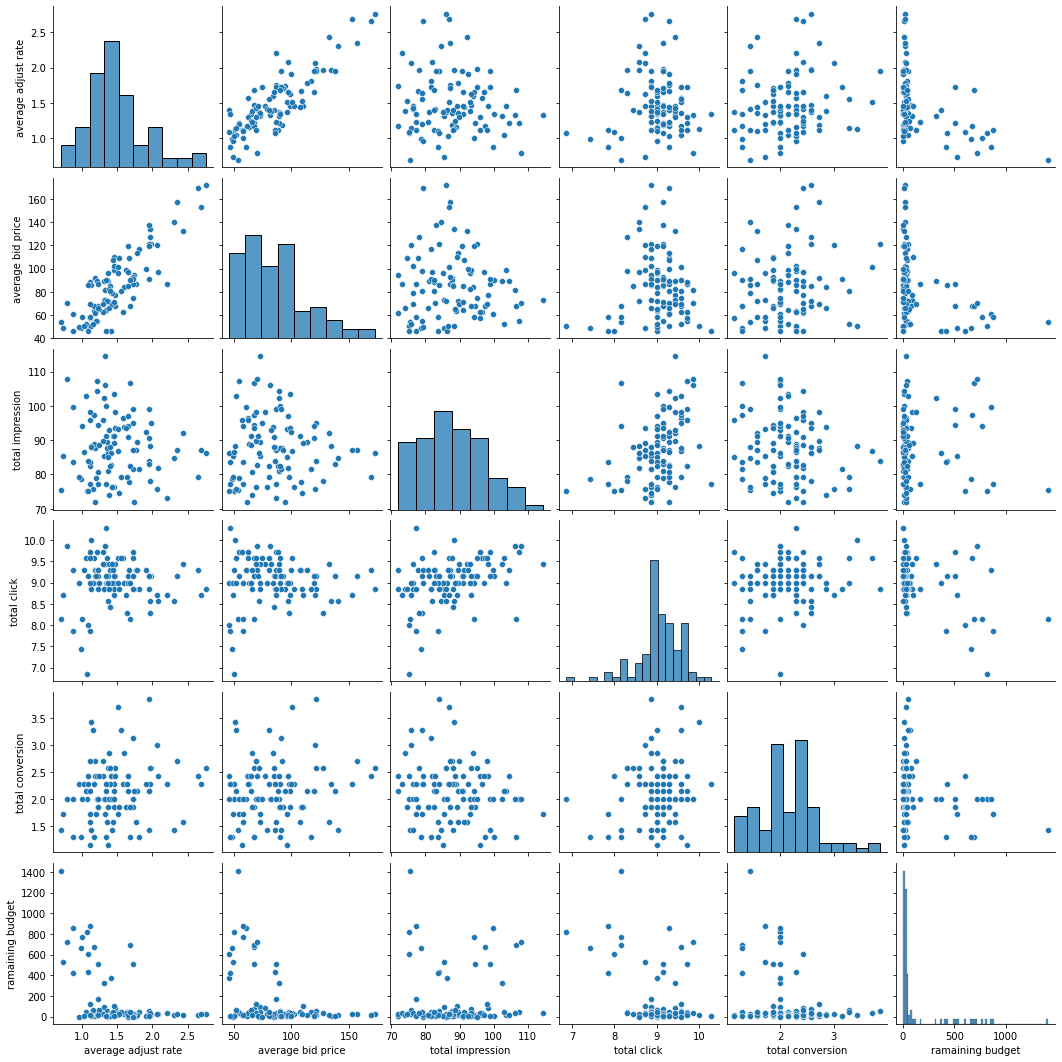

In [40]:
# the result reveals that there is slight negative correlation between bid price and impression
sns.pairplot(df_[:100])

For offline RL and OPE procedures, please refer to [examples/quickstart/rtb_synthetic_continuous_basic.ipynb](https://github.com/negocia-inc/rtb_reinforcement_learing/blob/ope/examples/quickstart/rtb_synthetic_continuous_basic.ipynb). \
For advanced topics in OPE and OPS, please refer to [examples/quickstart/rtb_synthetic_continuous_advanced.ipynb](https://github.com/negocia-inc/rtb_reinforcement_learing/blob/ope/examples/quickstart/rtb_synthetic_continuous_advanced.ipynb).

## Reference

- Yuta Saito, Shunsuke Aihara, Megumi Matsutani, and Yusuke Narita. \
"Open Bandit Dataset and Pipeline: Towards Realistic and Reproducible Off-Policy Evaluation.", 2021.

- Takuma Seno and Michita Imai. \
"d3rlpy: An Offline Deep Reinforcement Library.", 2021.

- Tuomas Haarnoja, Aurick Zhou, Pieter Abbeel, and Sergey Levine. \
"Soft Actor-Critic: Off-Policy Maximum Entropy Deep Reinforcement Learning with a Stochastic Actor." 2018.

- Di Wu, Xiujun Chen, Xun Yang, Hao Wang, Qing Tan, Xiaoxun Zhang, Jian Xu, and Kun Gai. \
"Budget Constrained Bidding by Model-free Reinforcement Learning in Display Advertising.", 2018.

- Jun Zhao, Guang Qiu, Ziyu Guan, Wei Zhao, and Xiaofei He. \
"Deep Reinforcement Learning for Sponsored Search Real-time Bidding.", 2018.

- Greg Brockman, Vicki Cheung, Ludwig Pettersson, Jonas Schneider, John Schulman, Jie Tang, and Wojciech Zaremba. \
"OpenAI Gym.", 2016.

- Hado van Hasselt, Arthur Guez, and David Silver. \
"Deep Reinforcement Learning with Double Q-learning.", 2015.